## X-axis Result Visualization

In this notebook, we compare our predicted model result with actual ball position by visualizing them.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import division

import json
import pickle
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
from IPython import display
from scipy.ndimage.interpolation import shift
import matplotlib.lines as mlines
import operator
from sklearn.externals import joblib
import scipy as sc

# our common utility functions that are used in different notebooks
from utils import *


pd.options.display.max_columns = None
pd.set_option('compute.use_bottleneck', True)
pd.set_option('compute.use_numexpr', True)

### Get data

In [3]:
match_id = 60866

try:
    features_df = pd.read_csv('../data/general/feature-set/match{}_features_3.csv'.format(match_id))
    player_pos_df = pd.read_csv('players_pos_{}.csv'.format(match_id))
except FileNotFoundError:
    assert False, "File not found error!"

In [4]:
features_df.tail()

# refX      refY  refSpeed  refDirectX  refDirectY  teamsAvgSpeed  \
2431  39.06250  48.06250  3.080078        -1.0         1.0       2.595703   
2432  37.25000  50.09375  2.419922        -1.0         1.0       2.636719   
2433  35.31250  51.18750  2.369141        -1.0         1.0       2.519531   
2434  33.09375  52.09375  2.609375        -1.0         1.0       2.691406   
2435  30.43750  52.78125  2.609375        -1.0         1.0       2.625000   

      teamsMinSpeed  teamMaxSpeed  teamsMaxSprint  teamsDBSCANx  teamsDBSCANy  \
2431       1.059570      4.308594        4.308594      46.96875     36.250000   
2432       1.219727      3.839844        3.839844      45.21875     37.656250   
2433       0.979980      4.910156        4.910156      43.84375     39.406250   
2434       1.120117      5.699219        5.699219      41.96875     40.718750   
2435       1.030273      5.699219        5.699219      23.84375     27.078125   

      homeDBSCANx  homeDBSCANy  homeMaxX   homeMinX  homeMaxY   homeMinY  \
2431     45.81250     34.21875   69.3125  26.015625  57.34375  11.695312   
2432     43.96875     35.93750   67.6875  23.265625  59.31250  17.109375   
2433     42.87500     38.53125   66.1250  21.562500  61.37500  21.718750   
2434     40.93750     40.43750   68.0625  19.687500  62.15625  22.515625   
2435     38.00000     41.68750   66.6875  16.531250  63.53125  22.718750   

      homeAvgX  homeAvgY  homeAvgSpeed  homeMinSpeedX  homeMinSpeedY  \
2431  45.81250  34.21875      2.962891      69.312500      21.765625   
2432  43.96875  35.93750      2.968750      67.687500      22.078125   
2433  42.87500  38.53125      2.873047      25.671875      24.718750   
2434  40.93750  40.43750      3.181641      68.062500      27.625000   
2435  38.00000  41.68750      3.105469      66.687500      27.781250   

      homeMinSpeed  homeMaxSpeedX  homeMaxSpeedY  homeMaxSpeed  \
2431      1.559570       46.78125       40.53125      4.378906   
2432      1.660156       44.18750       44.59375      4.878906   
2433      1.509766       42.00000       48.21875      4.910156   
2434      1.419922       39.31250       51.03125      5.699219   
2435      1.339844       36.37500       53.65625      5.859375   

      homeMaxSprintX  homeMaxSprintY  homeMaxSprint  homeGoalKeeperX  \
2431       46.781250        40.53125       4.378906         3.531250   
2432       58.531250        45.90625       4.878906         3.546875   
2433       53.937500        46.81250       4.910156         3.500000   
2434       24.765625        59.78125       5.699219         2.794922   
2435       19.765625        63.53125       5.859375         1.875000   

      homeGoalKeeperY  homeGoalKeeperSpeed  homeLeftBackMaxX  \
2431         35.37500             0.360107          63.40625   
2432         35.65625             0.419922          58.53125   
2433         36.09375             0.640137          53.93750   
2434         36.46875             1.000000          49.46875   
2435         36.71875             0.810059          44.40625   

      homeLeftBackMinX  homeLeftBackMaxY  homeLeftBackMinY  homeLeftBackAvgX  \
2431          63.40625          45.90625          45.90625          63.40625   
2432          58.53125          45.90625          45.90625          58.53125   
2433          53.93750          46.81250          46.81250          53.93750   
2434          49.46875          48.06250          48.06250          49.46875   
2435          44.40625          49.06250          49.06250          44.40625   

      homeLeftBackAvgY  homeLeftBackAvgSpeed  homeLeftBackSlowAvgX  \
2431          45.90625              4.269531                   0.0   
2432          45.90625              4.878906                   0.0   
2433          46.81250              4.910156                   0.0   
2434          48.06250              4.921875                   0.0   
2435          49.06250              4.839844                   0.0   

      homeLeftBackSlowAvgY  homeLeftBackHirAvgX  ho

In [6]:
player_pos_df.tail()

# hx1        hx2       hx3        hx4       hx5       hx6       hx7  \
2431  26.015625  29.750000  62.71875  27.109375  69.31250  46.78125  69.06250   
2432  23.265625  30.093750  64.06250  26.406250  67.68750  44.18750  62.96875   
2433  21.562500  28.437500  65.93750  25.671875  66.12500  42.00000  64.81250   
2434  19.687500  24.765625  64.43750  24.812500  64.68750  39.31250  68.06250   
2435  16.531250  19.765625  62.84375  23.843750  63.03125  36.37500  66.68750   

            hx8       hx9       hx10       hy1       hy2        hy3  \
2431  35.468750  63.40625  28.375000  37.43750  49.00000  11.695312   
2432  34.281250  58.53125  28.187500  38.06250  53.21875  18.125000   
2433  33.000000  53.93750  27.156250  39.34375  56.59375  23.671875   
2434  31.203125  49.46875  22.875000  40.59375  59.78125  23.859375   
2435  28.906250  44.40625  17.578125  40.59375  63.53125  23.953125   

            hy4        hy5       hy6        hy7       hy8       hy9      hy10  \
2431  21.765625  21.765625  40.53125  22.843750  33.87500  45.90625  57.34375   
2432  23.390625  22.078125  44.59375  17.109375  37.53125  45.90625  59.31250   
2433  24.718750  22.375000  48.21875  21.718750  40.59375  46.81250  61.37500   
2434  25.828125  22.515625  51.03125  27.625000  43.00000  48.06250  62.15625   
2435  27.078125  22.718750  53.65625  27.781250  45.09375  49.06250  63.34375   

          ax1       ax2        ax3       ax4        ax5        ax6       ax7  \
2431  69.7500  64.56250  36.250000  43.81250  24.203125  32.281250  61.53125   
2432  67.6250  63.34375  35.218750  42.31250  20.656250  30.875000  60.84375   
2433  65.6250  62.34375  34.312500  40.00000  18.937500  29.562500  60.03125   
2434  63.8125  61.31250  33.062500  36.78125  18.078125  28.265625  59.00000   
2435  62.1250  60.06250  30.921875  33.03125  16.687500  26.812500  57.87500   

            ax8       ax9      ax10       ay1        ay2       ay3       ay4  \
2431  35.593750  62.84375  50.68750  45.59375  28.234375  51.68750  48.46875   
2432  32.906250  61.31250  49.75000  46.31250  28.937500  55.81250  51.15625   
2433  28.562500  60.00000  48.81250  47.21875  29.515625  59.00000  52.62500   
2434  23.265625  58.56250  47.84375  48.06250  29.953125  61.40625  52.71875   
2435  17.328125  57.06250  46.78125  48.81250  30.406250  63.31250  52.34375   

           ay5        ay6       ay7       ay8        ay9      ay10  
2431  36.15625  13.445312  37.31250  63.71875  19.765625  38.53125  
2432  34.68750  14.039062  38.81250  63.40625  21.187500  39.37500  
2433  34.28125  14.632812  39.81250  63.50000  22.000000  40.00000  
2434  34.31250  15.304688  40.53125  64.50000  22.593750  40.50000  
2435  34.15625  15.976562  41.09375  65.62500  23.125000  41.00000

#### Generate 200 random data point

In [15]:
idx = np.random.choice(np.arange(len(features_df)), 200, replace=False)

In [16]:
X = features_df.values[idx, 0:-4]

# Scale the data to be between -1 and 1
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

y_x = features_df.values[idx, -3]
y_y = features_df.values[idx, -2]
players_position = player_pos_df.values[idx, :]

## Visualization

#### Visualization function

In [11]:
def plot_position(home_team_x, home_team_y, away_team_x, away_team_y, y_x, y_y, p_y_x, p_y_y):
    
    font = {'size'   : 23}
    matplotlib.rc('font', **font)

    width, height = 105, 68
    plt.figure(figsize=(10, 10*height/width))

    plt.xlabel('Distance (m)')
    plt.ylabel('Distance (m)')

    size = 250
    ax = plt.gca()
    mid_circ = plt.Circle((52.5, 34), 9.15, color='black', fill=False, linewidth=0.6, zorder=1)
    left_pen_circ = plt.Circle((11, 34), 0.3, color='black', fill=True, linewidth=0.6, zorder=1)
    right_pen_circ = plt.Circle((94, 34), 0.3, color='black', fill=True, linewidth=0.6, zorder=1)
    # middle line
    ax.add_line(mlines.Line2D((52, 52), (0, 68), color='black', linewidth=0.6, zorder=1))

    # circles
    ax.add_artist(mid_circ)
    ax.add_artist(left_pen_circ)
    ax.add_artist(right_pen_circ)

    # left part
    ax.add_line(mlines.Line2D((0, 16.5), (13.84, 13.84), color='black', linewidth=0.6, zorder=1))
    ax.add_line(mlines.Line2D((0, 16.5), (54.16, 54.16), color='black', linewidth=0.6, zorder=1))
    ax.add_line(mlines.Line2D((16.5, 16.5), (13.84, 54.16), color='black', linewidth=0.6, zorder=1))

    ax.add_line(mlines.Line2D((0, 5.5), (24.84, 24.84), color='black', linewidth=0.6, zorder=1))
    ax.add_line(mlines.Line2D((0, 5.5), (43.16, 43.16), color='black', linewidth=0.6, zorder=1))
    ax.add_line(mlines.Line2D((5.5, 5.5), (24.84, 43.16), color='black', linewidth=0.6, zorder=1))

    # right part
    ax.add_line(mlines.Line2D((88.5, 105), (13.84, 13.84), color='black', linewidth=0.6, zorder=1))
    ax.add_line(mlines.Line2D((88.5, 105), (54.16, 54.16), color='black', linewidth=0.6, zorder=1))
    ax.add_line(mlines.Line2D((88.5, 88.5), (13.84, 54.16), color='black', linewidth=0.6, zorder=1))

    ax.add_line(mlines.Line2D((99.5, 105), (24.84, 24.84), color='black', linewidth=0.6, zorder=1))
    ax.add_line(mlines.Line2D((99.5, 105), (43.16, 43.16), color='black', linewidth=0.6, zorder=1))
    ax.add_line(mlines.Line2D((99.5, 99.5), (24.84, 43.16), color='black', linewidth=0.6, zorder=1))


    plt.scatter(home_team_x, home_team_y, s=50, zorder=2)

    plt.scatter(away_team_x, away_team_y, s=50, zorder=2)
    
    plt.scatter(y_x, y_y, label='Ball', s=150, zorder=2)
    plt.scatter(p_y_x, p_y_y, label='Prediction', s=150, zorder=2)
    
    plt.legend(loc=1)

    plt.show()

#### Load model and get predictions values

In [17]:
# read the previously trained model
with open('rfr_model_x.pkl', 'rb') as f:
    clf = pickle.load(f)
    
with open('rfr_model_y.pkl', 'rb') as f:
    clf2 = pickle.load(f)


In [18]:
p_y_x=clf.predict(X)
p_y_y=clf2.predict(X)

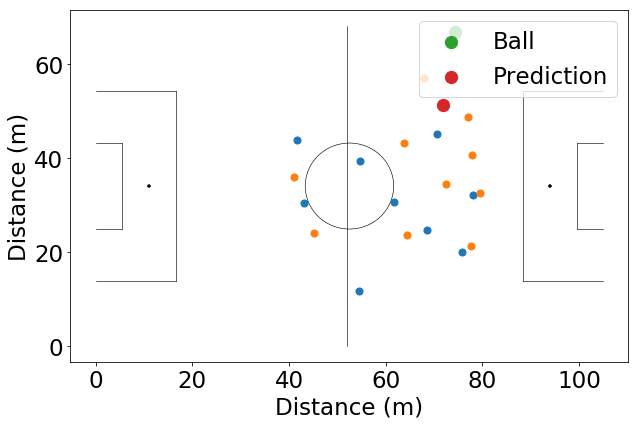

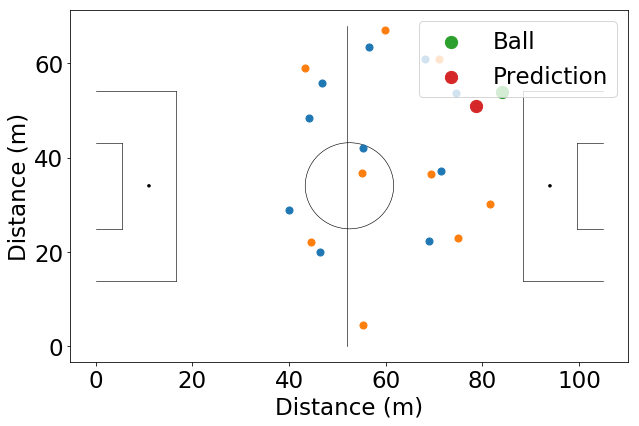

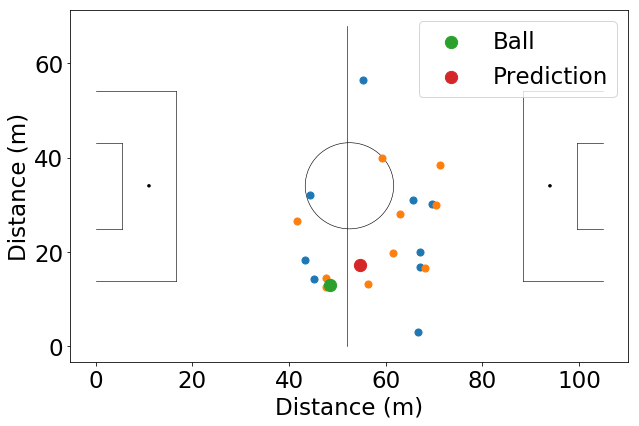

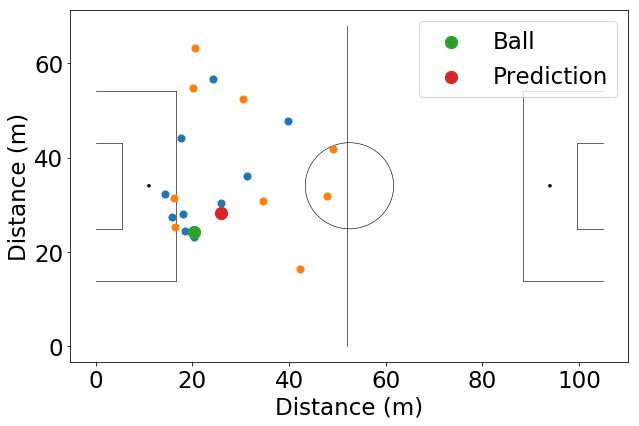

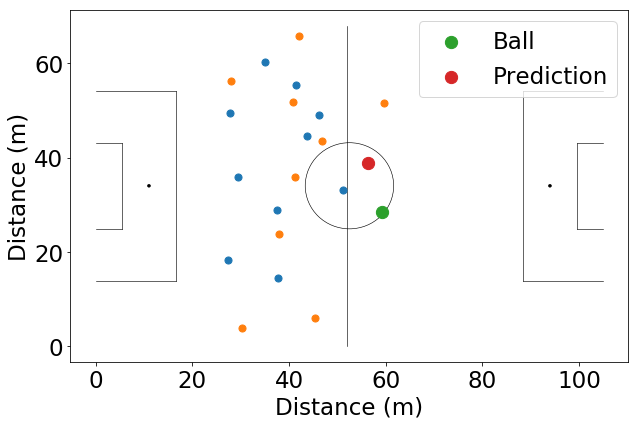

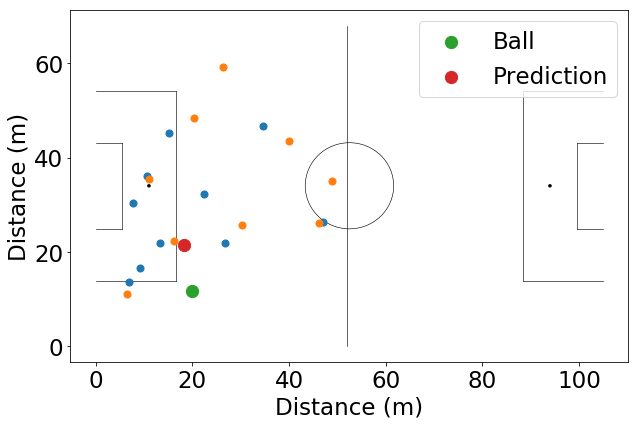

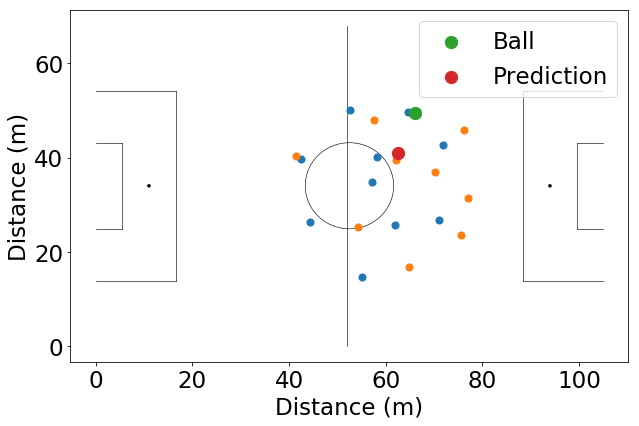

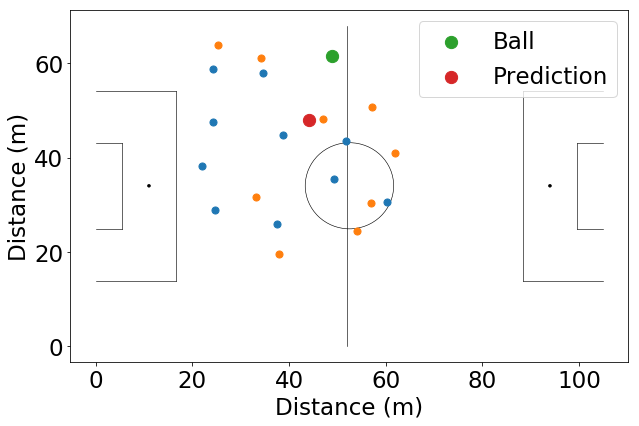

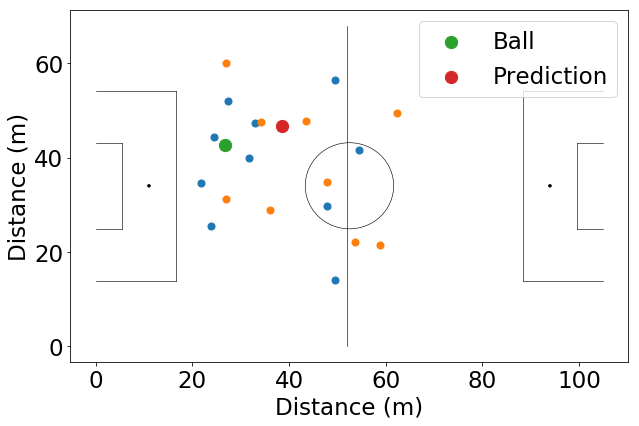

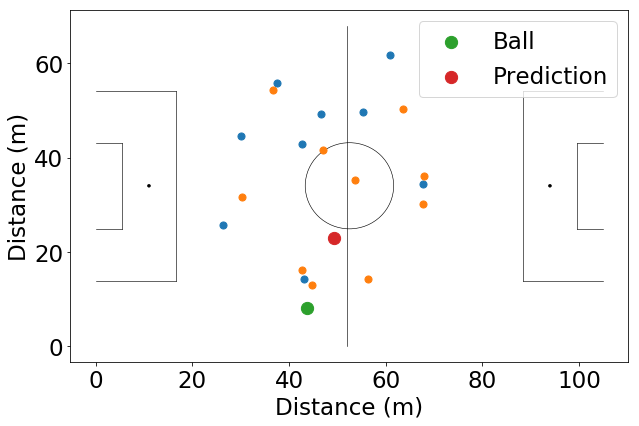

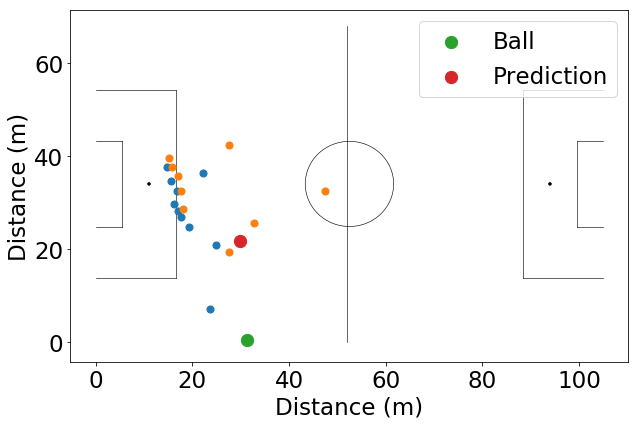

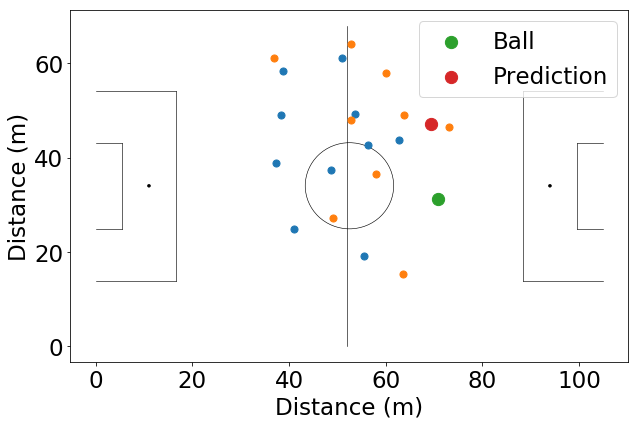

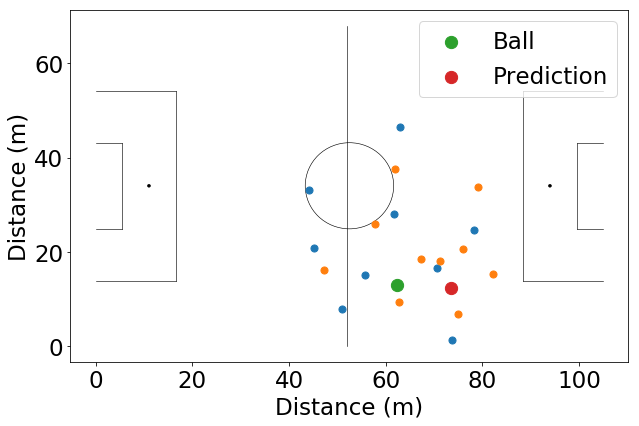

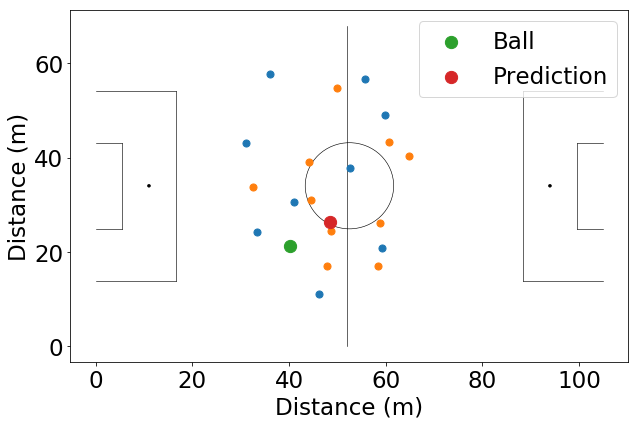

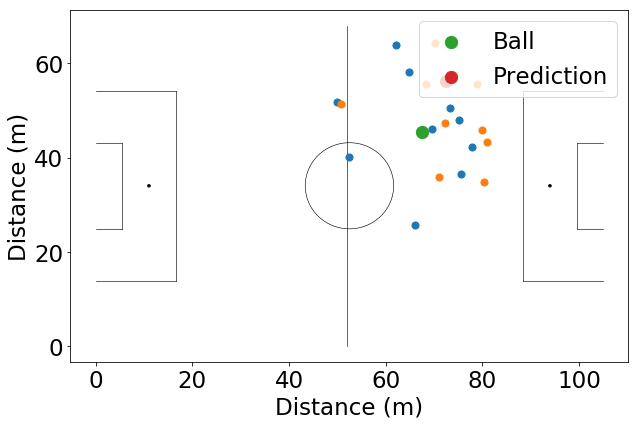

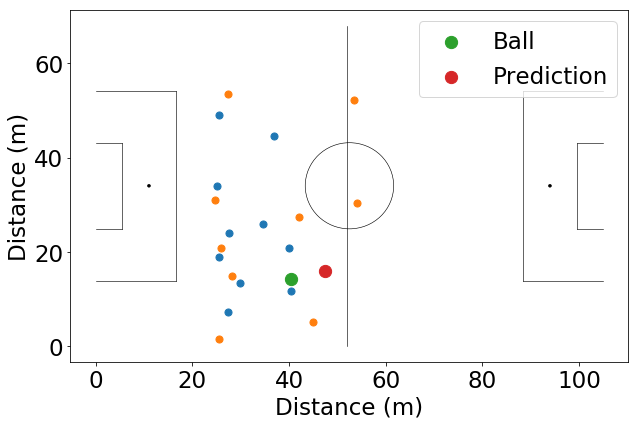

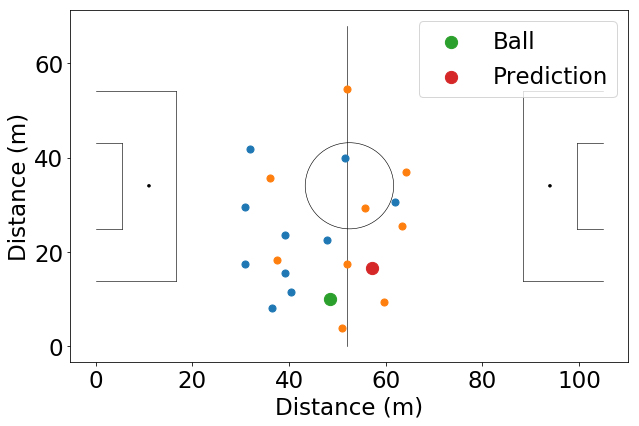

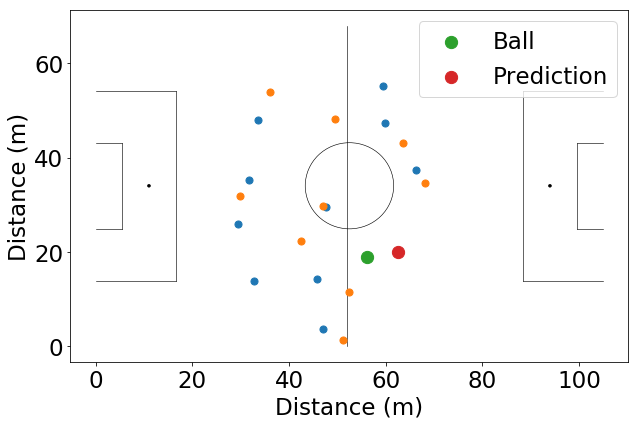

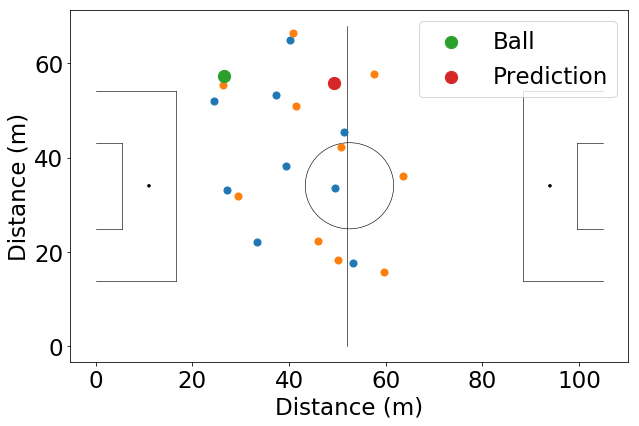

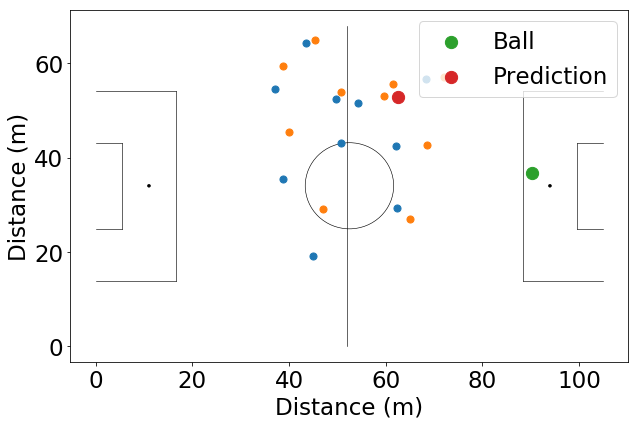

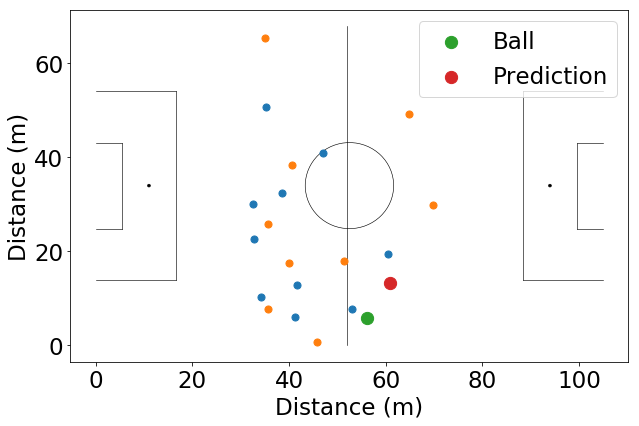

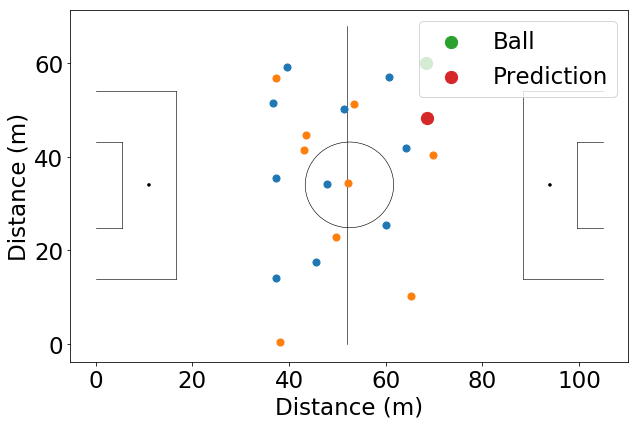

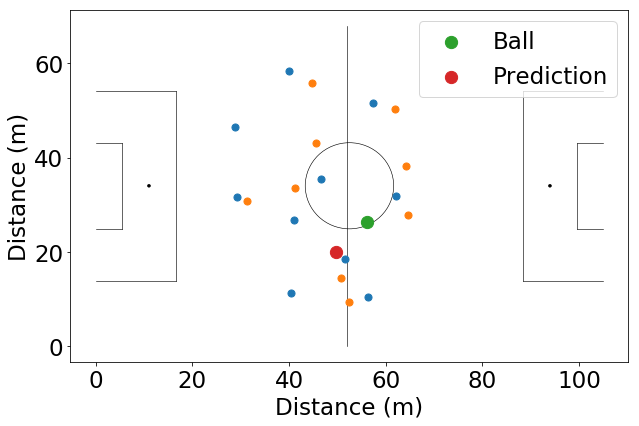

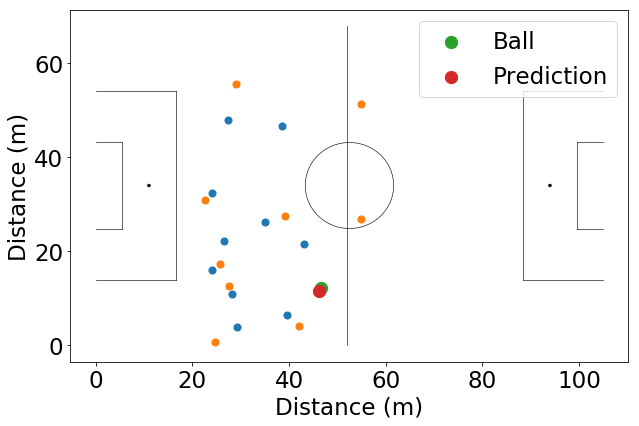

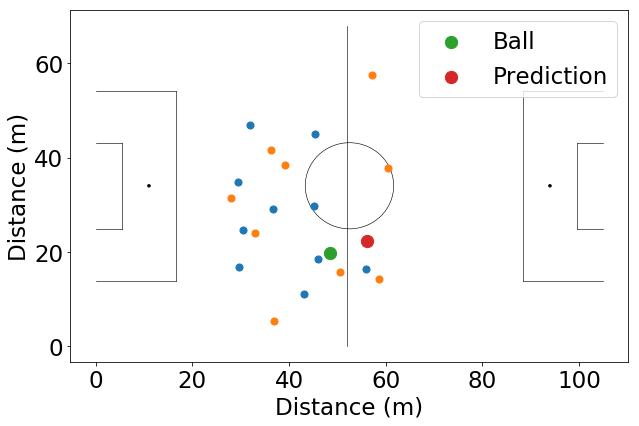

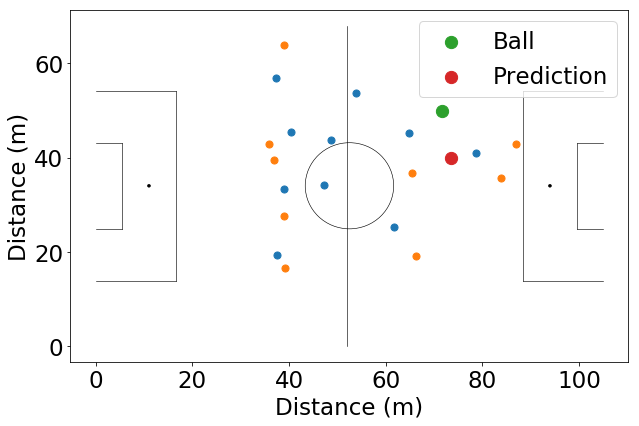

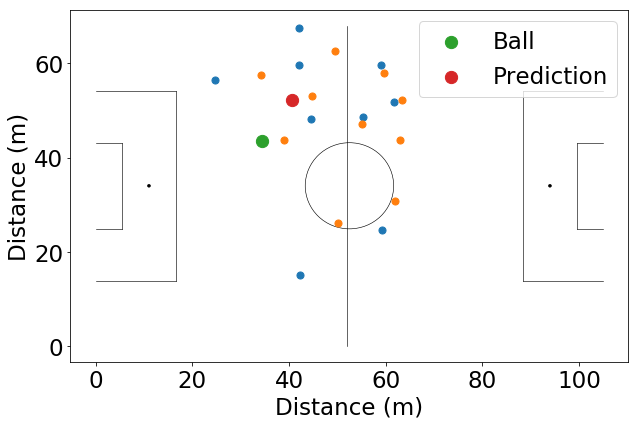

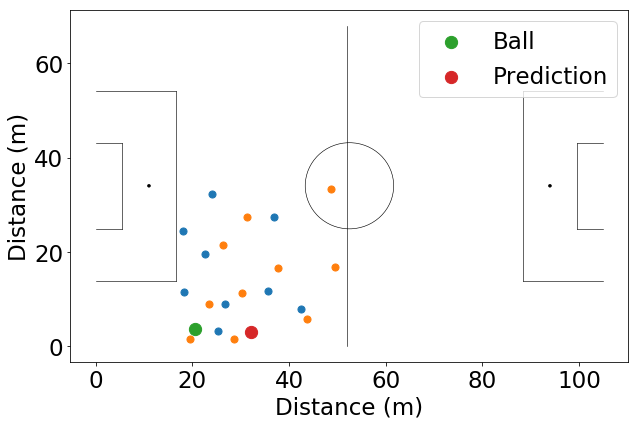

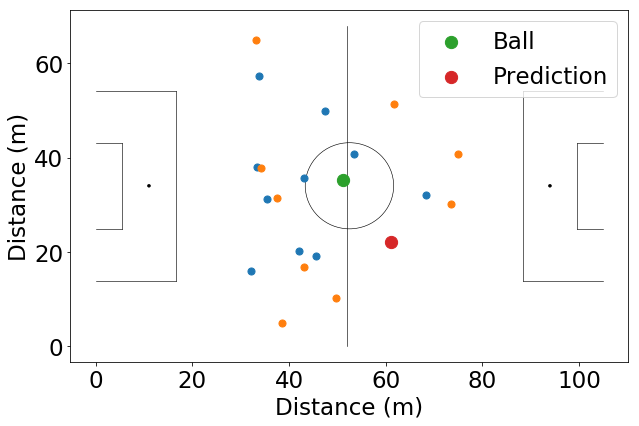

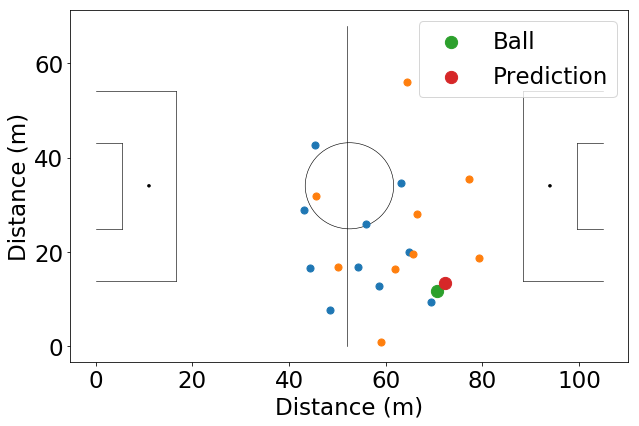

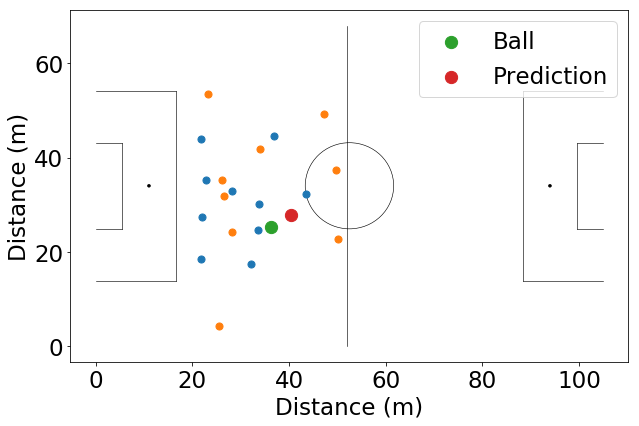

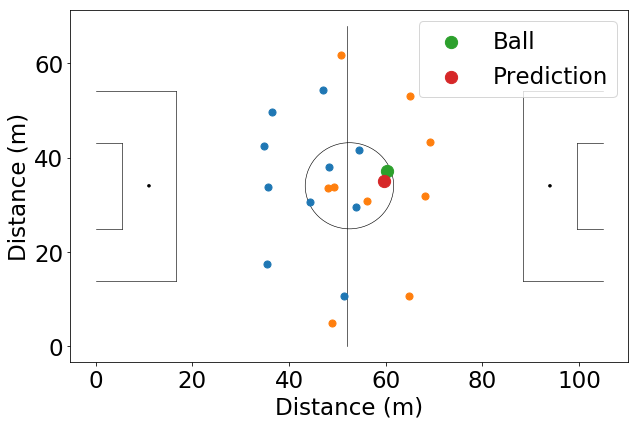

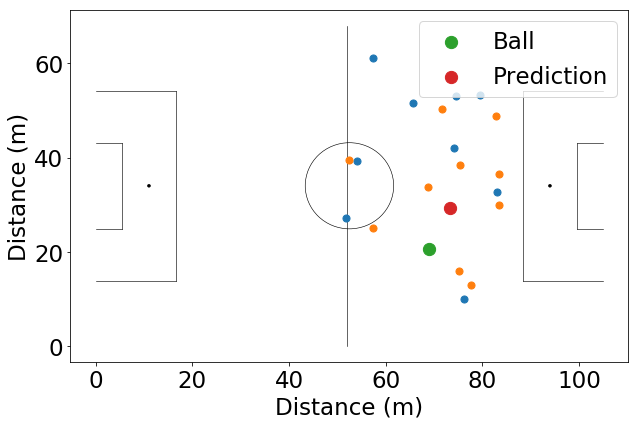

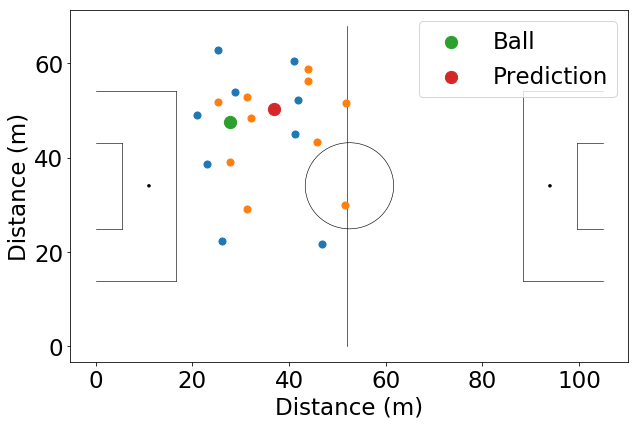

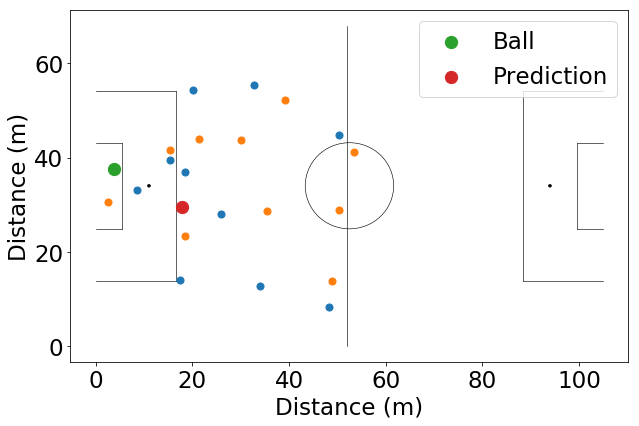

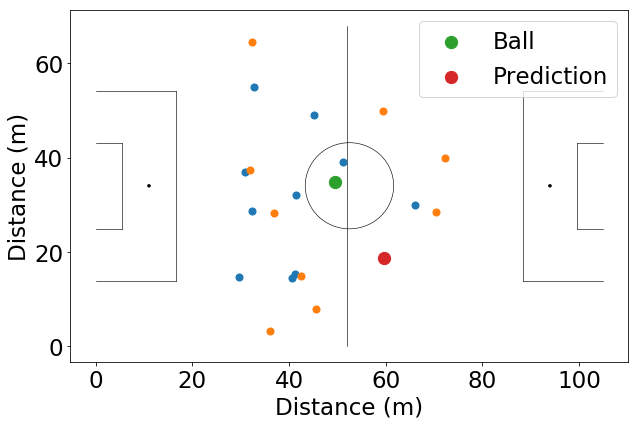

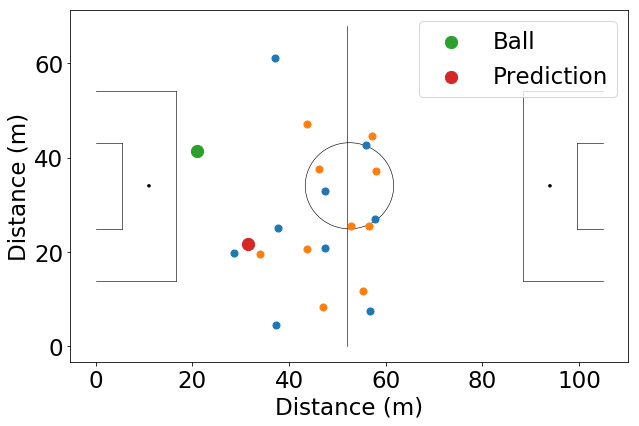

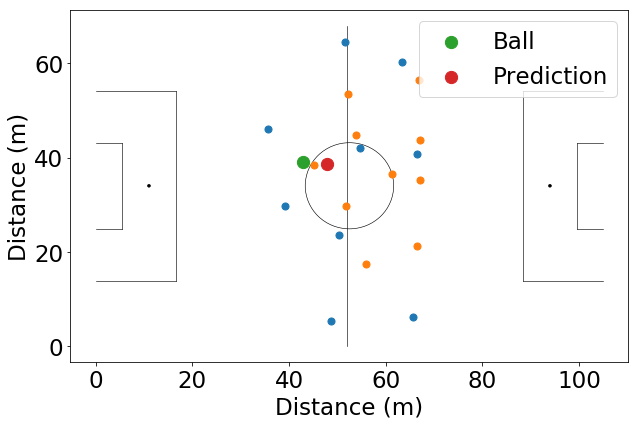

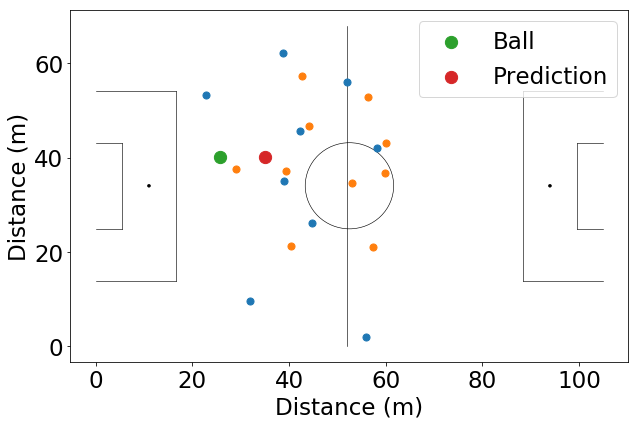

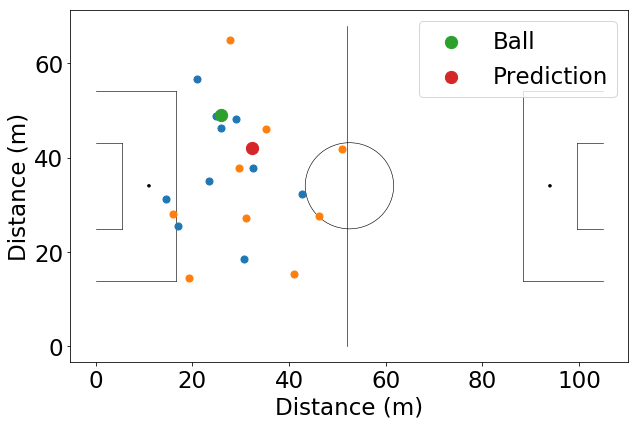

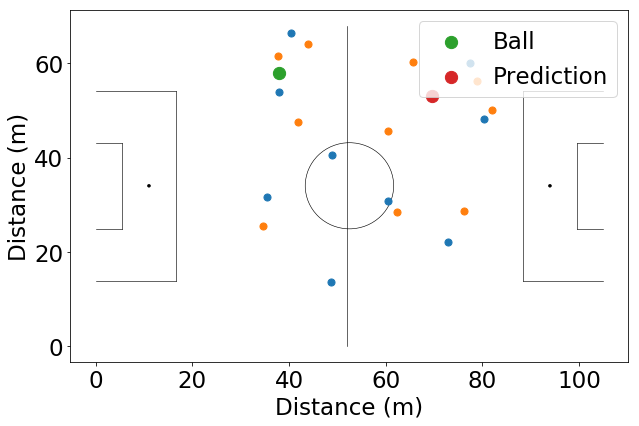

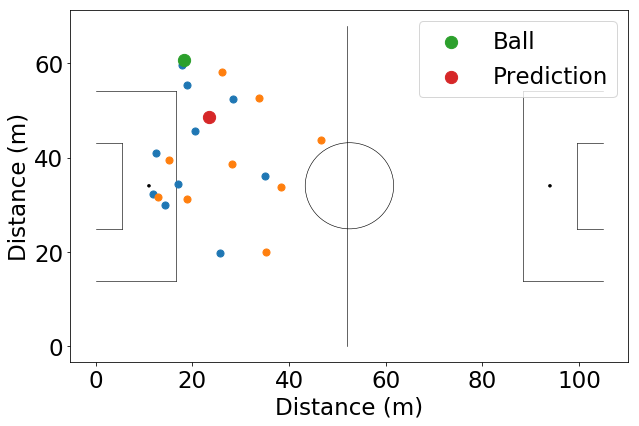

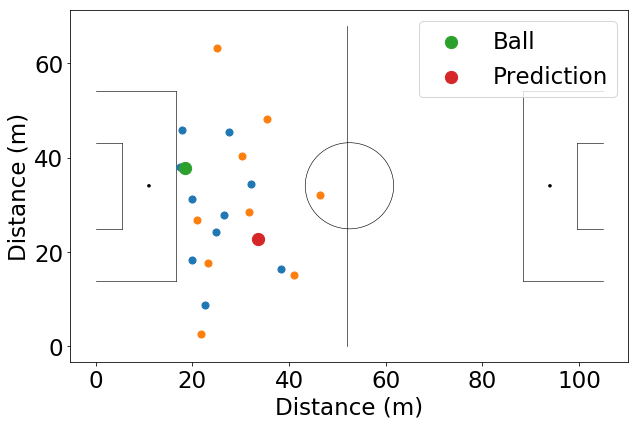

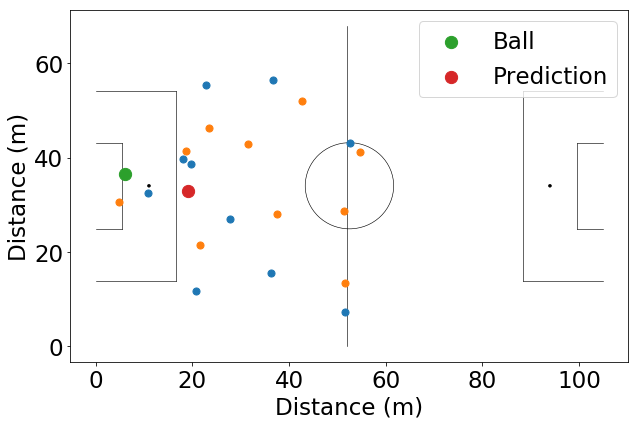

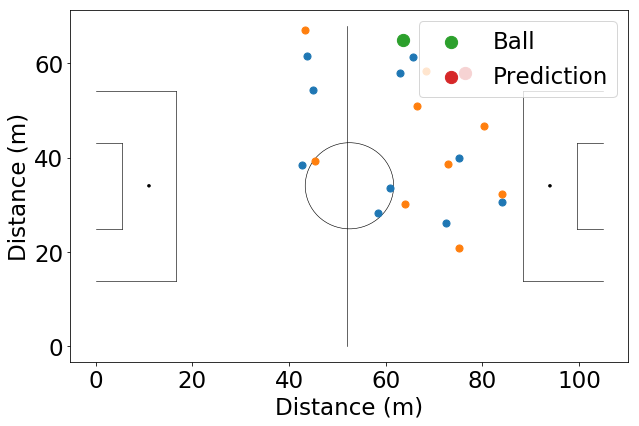

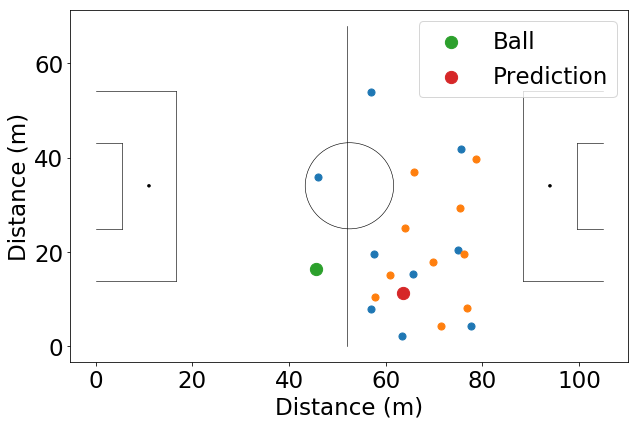

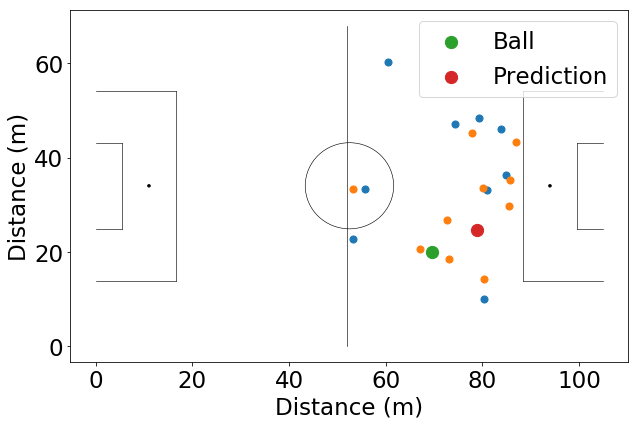

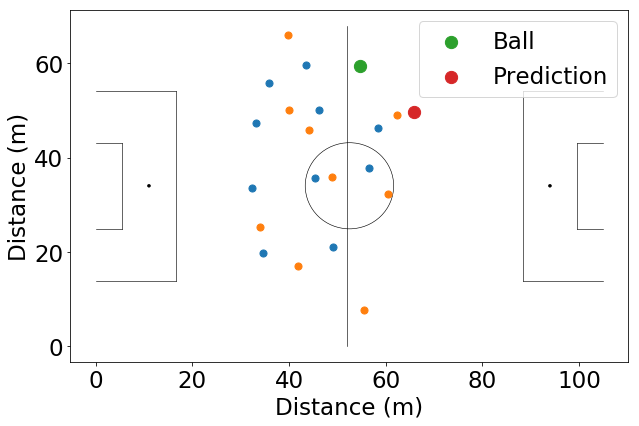

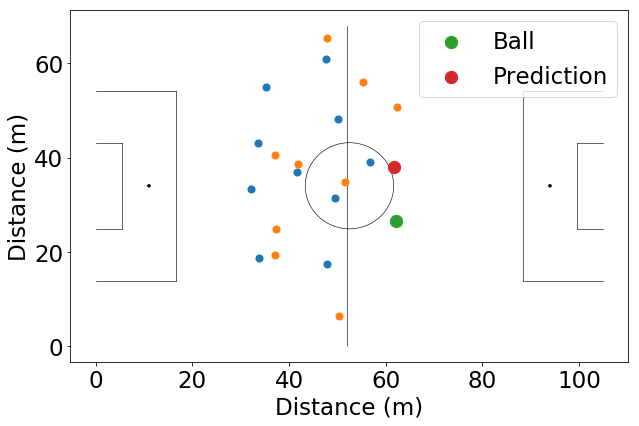

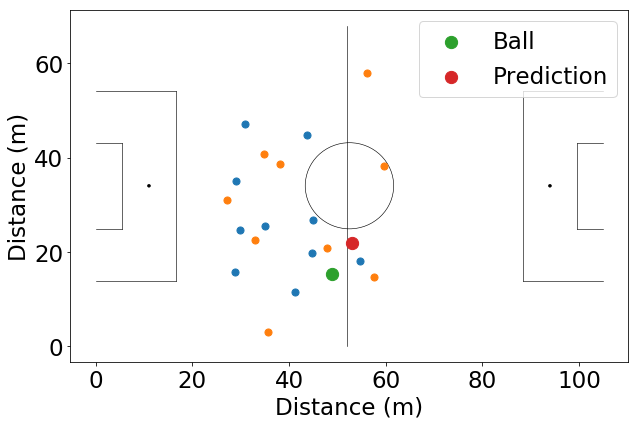

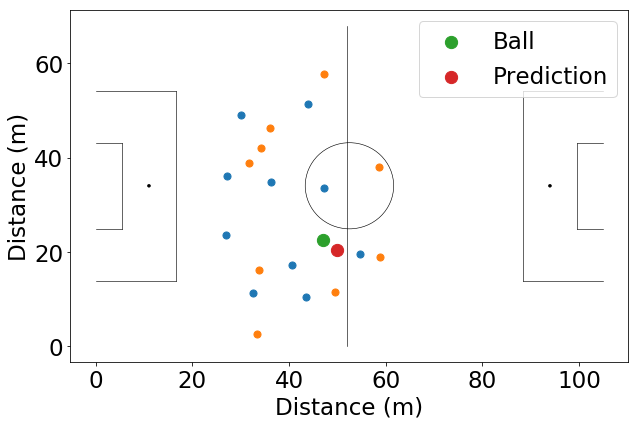

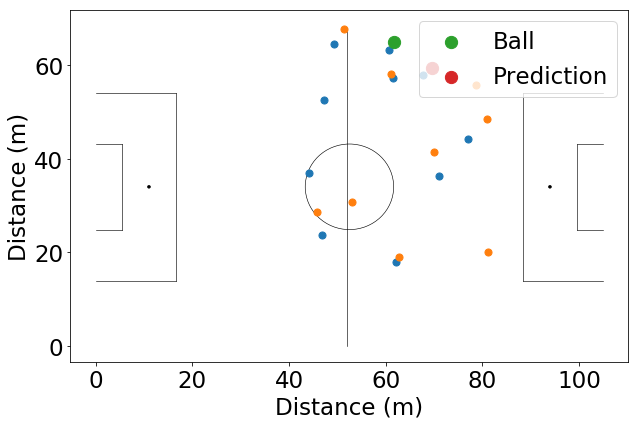

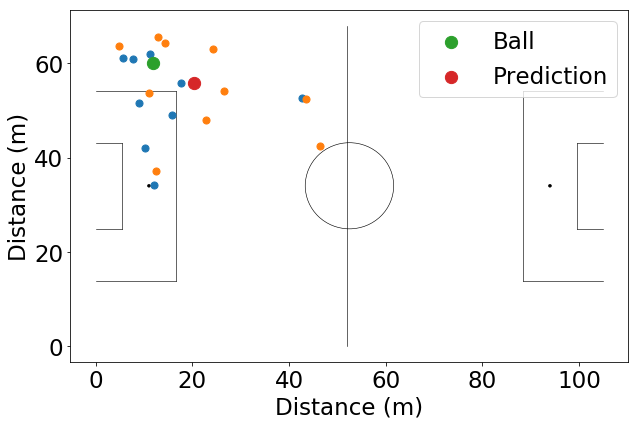

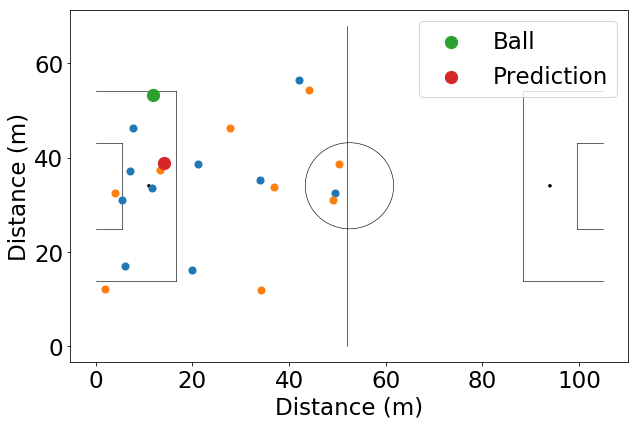

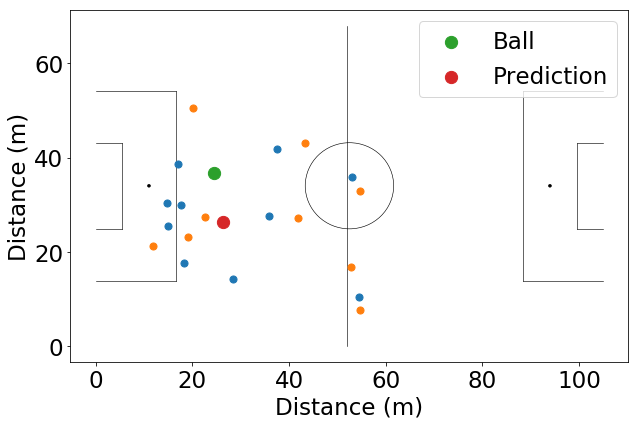

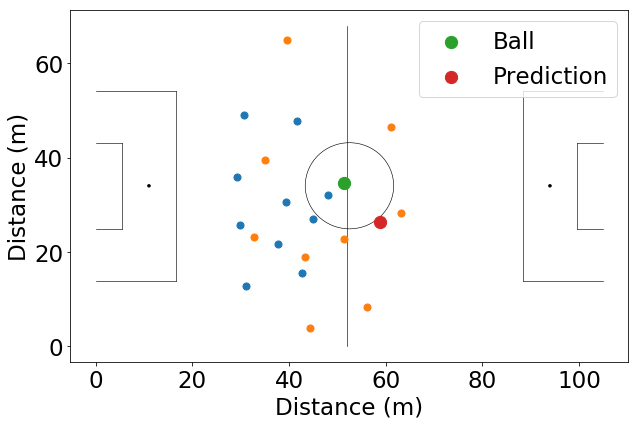

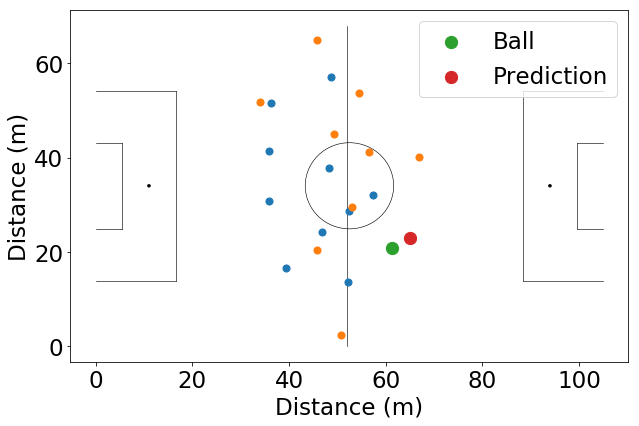

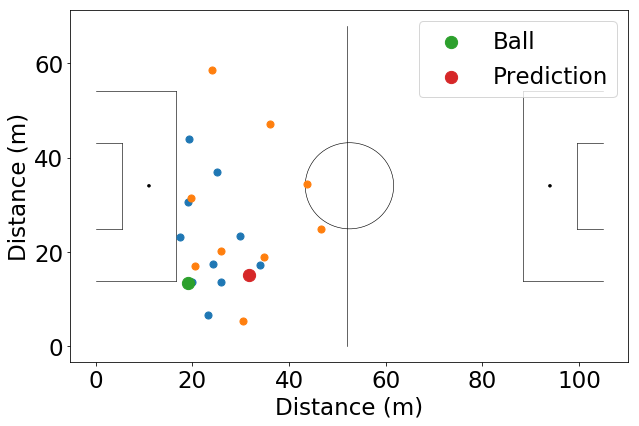

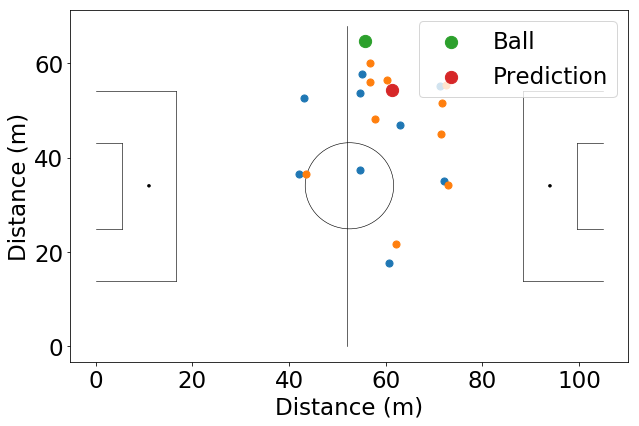

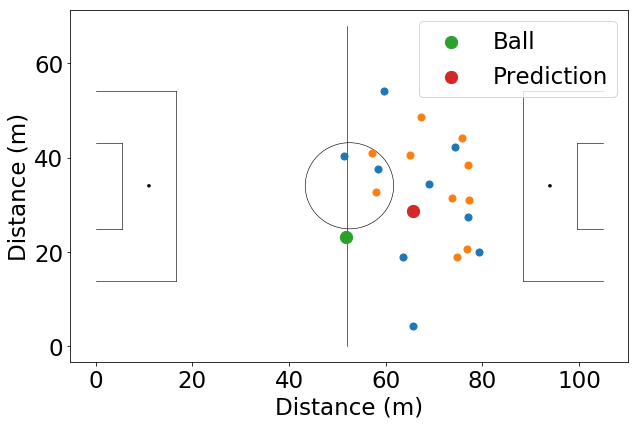

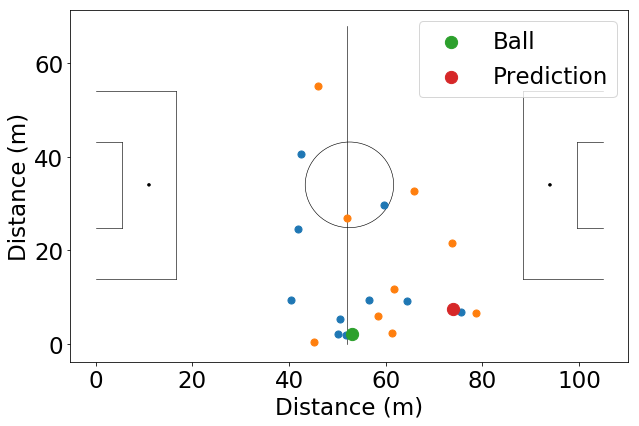

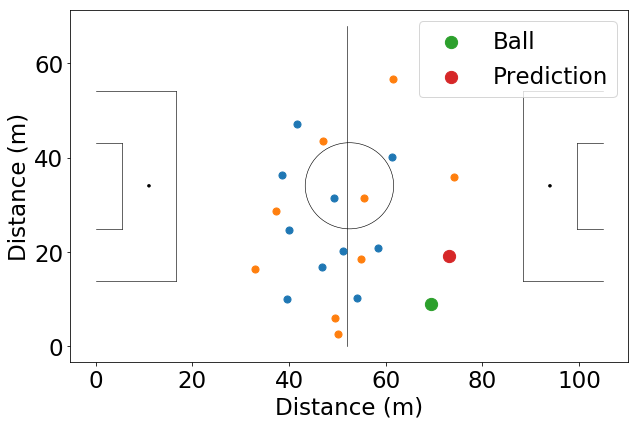

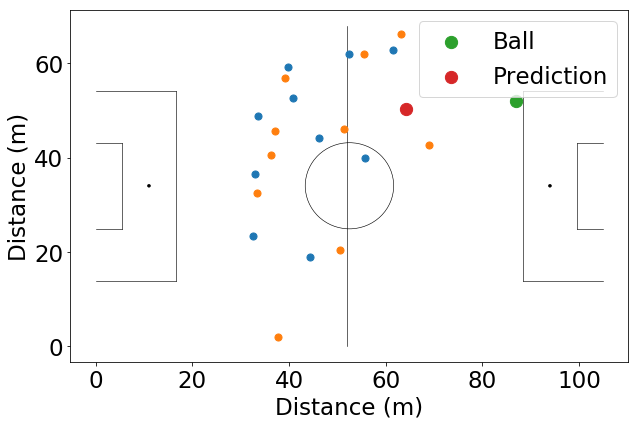

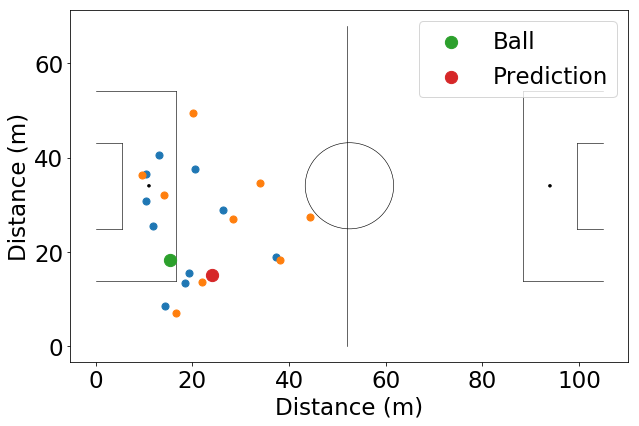

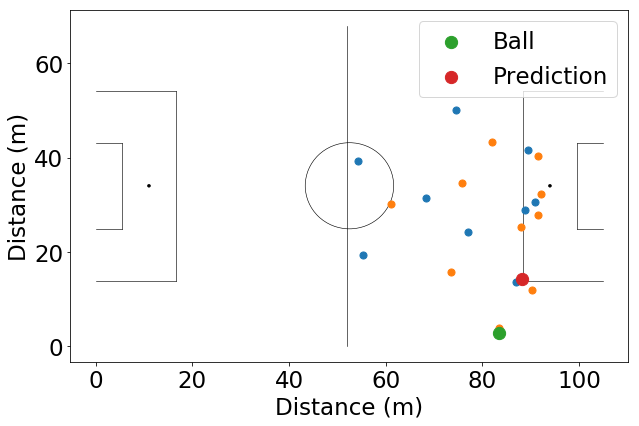

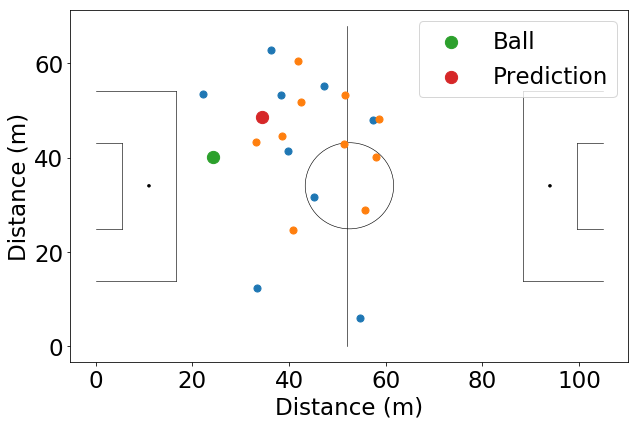

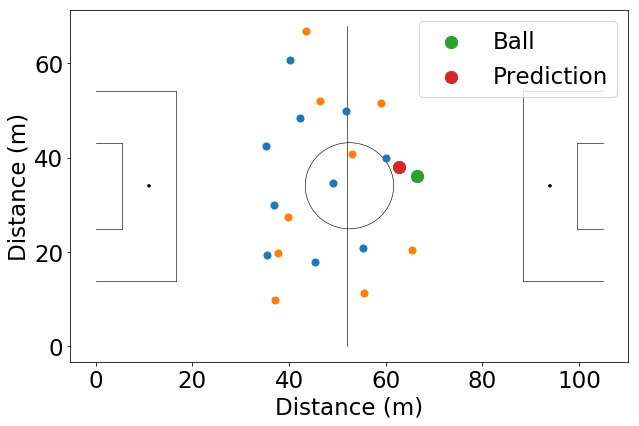

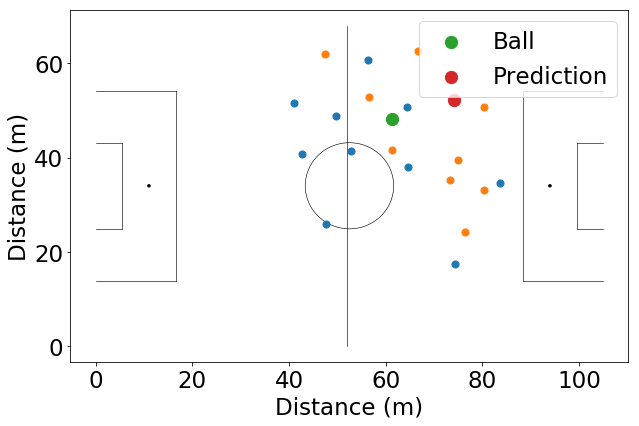

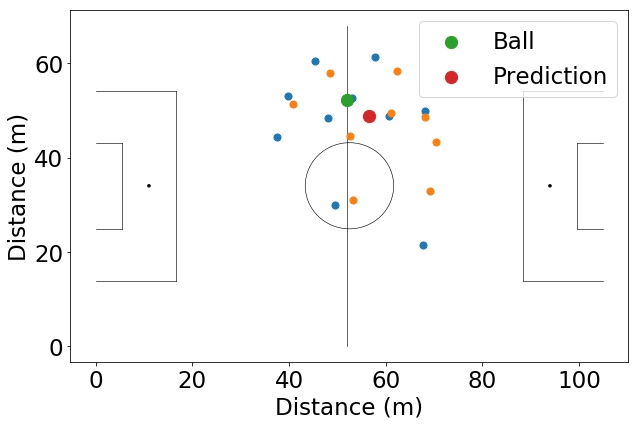

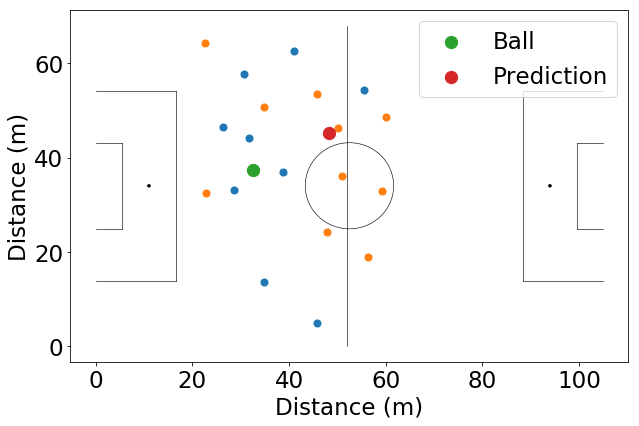

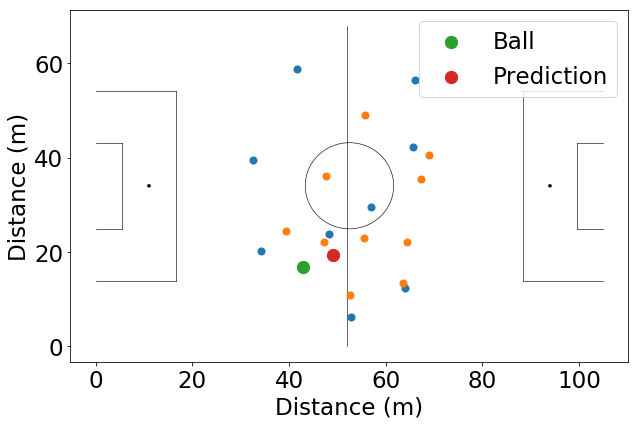

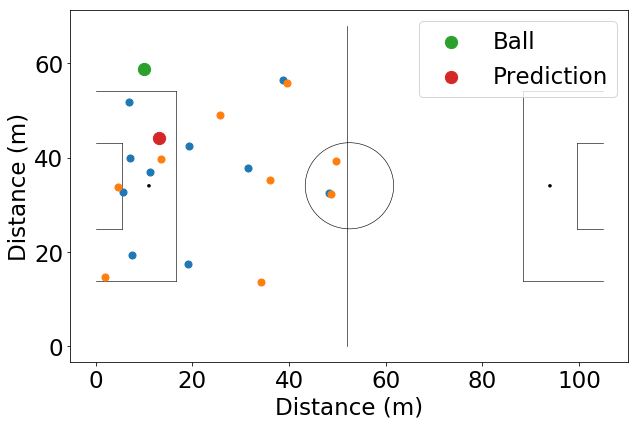

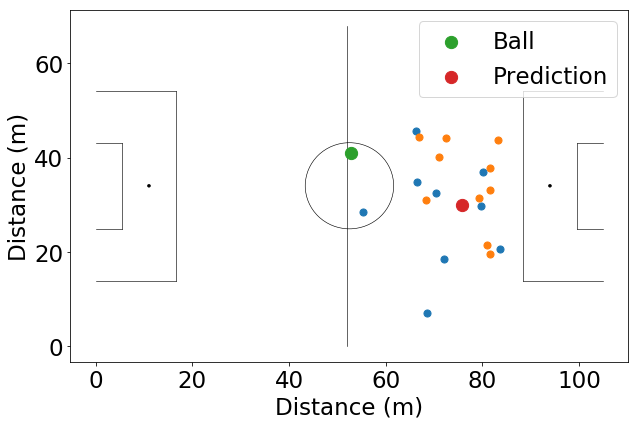

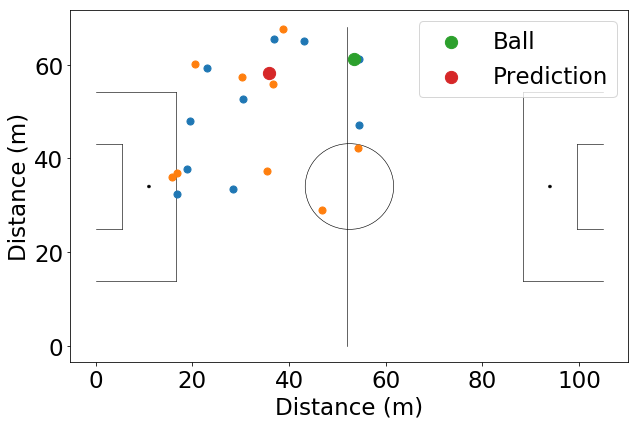

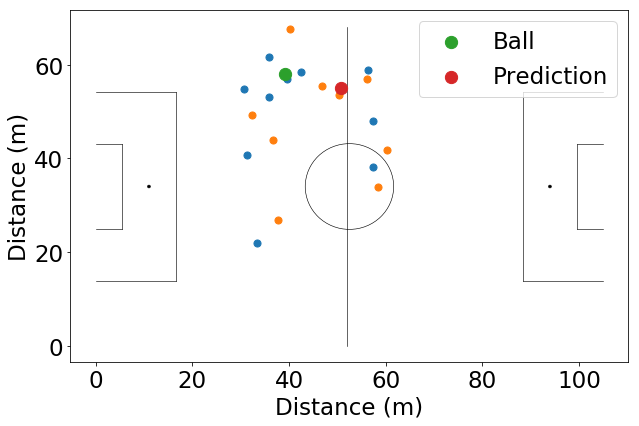

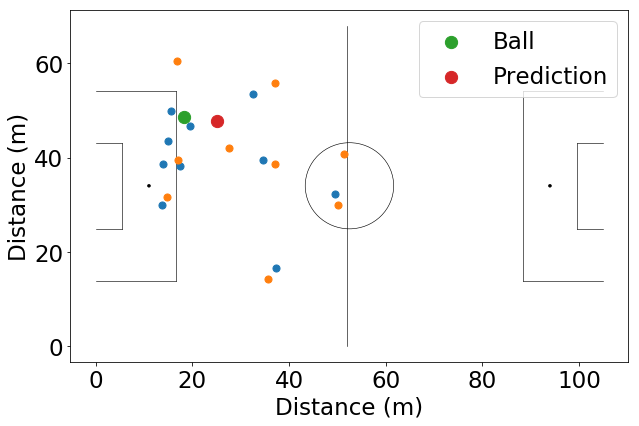

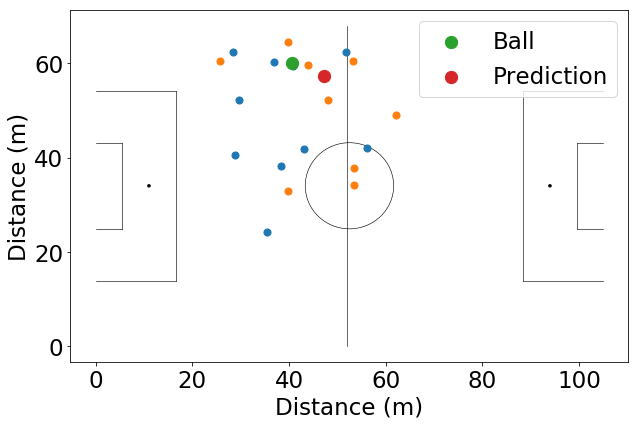

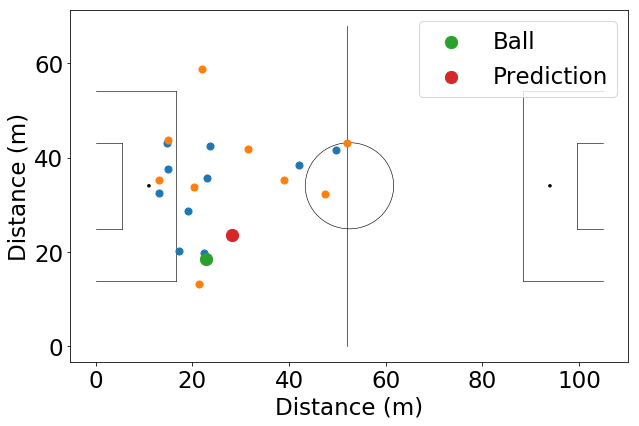

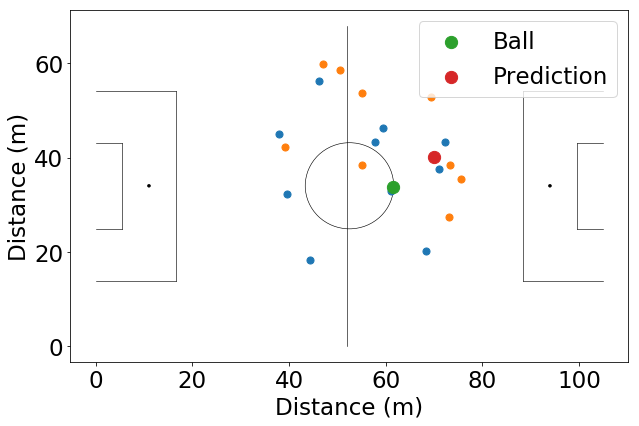

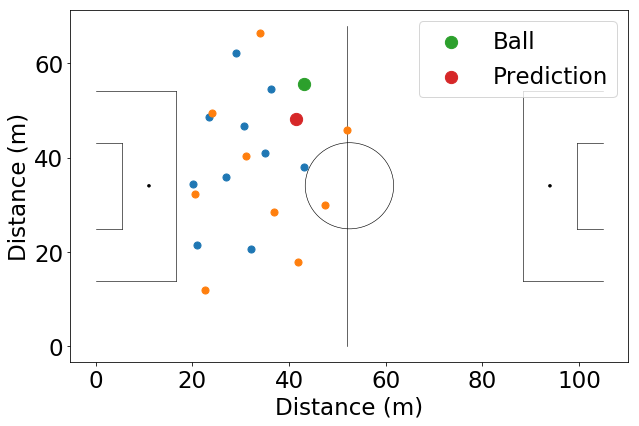

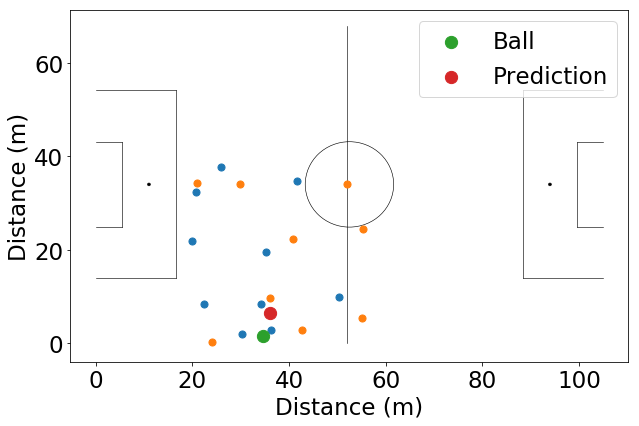

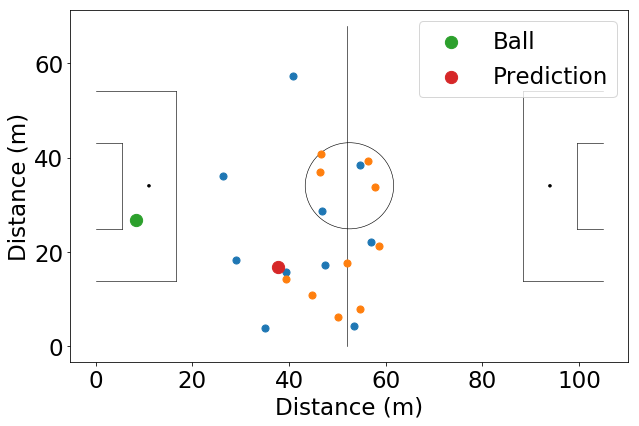

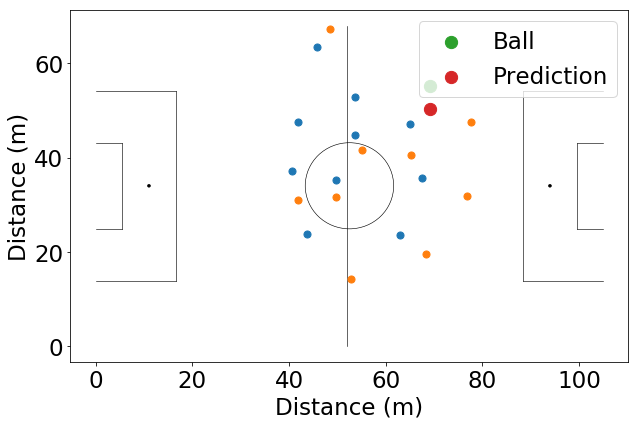

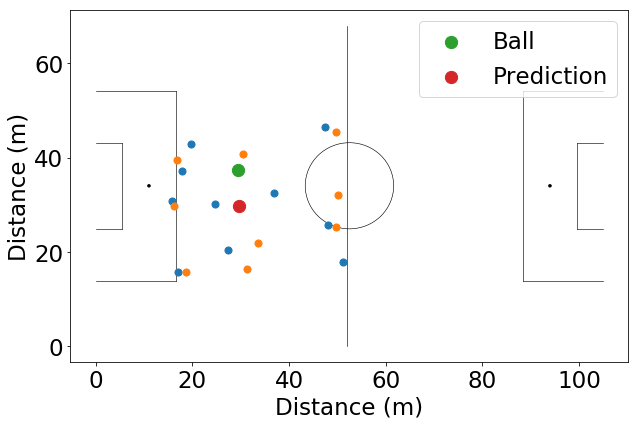

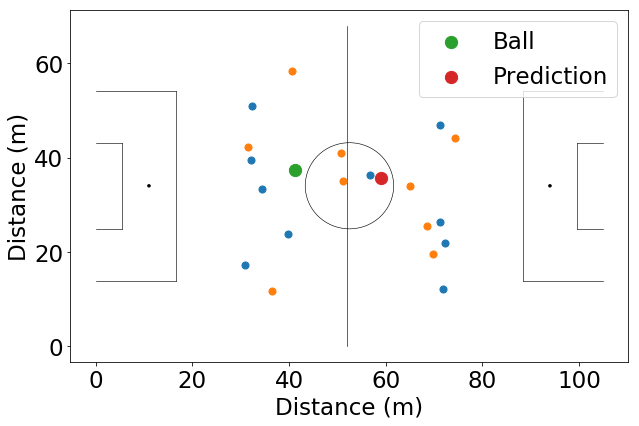

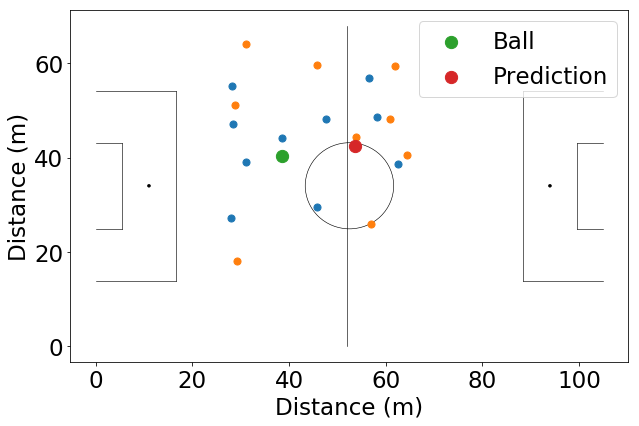

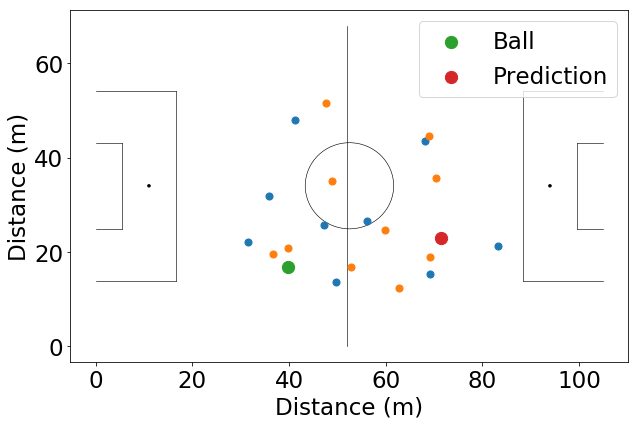

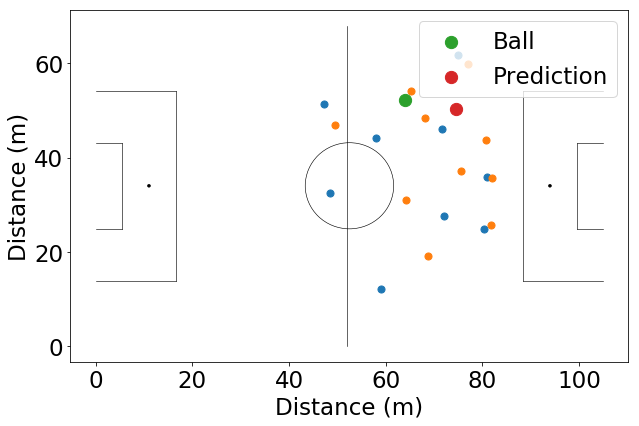

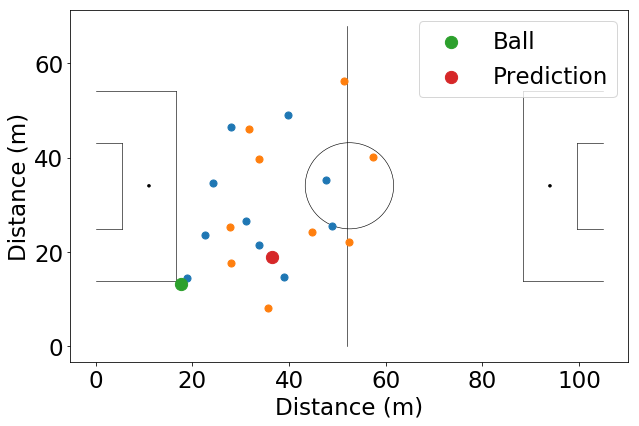

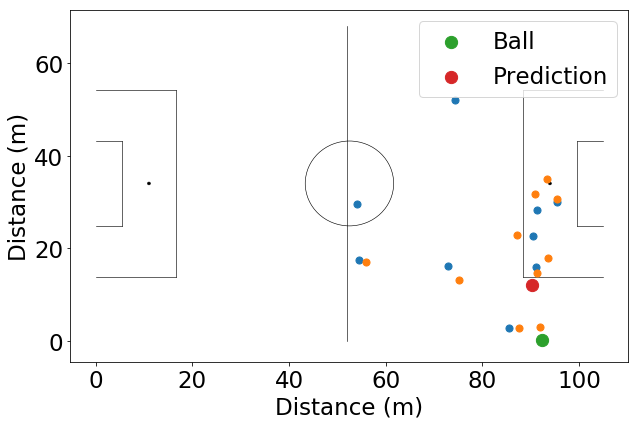

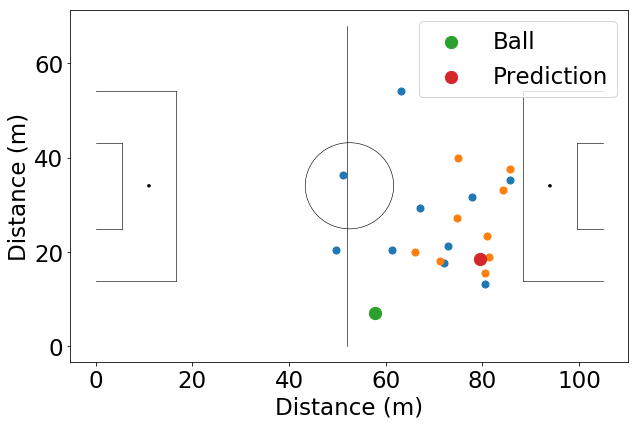

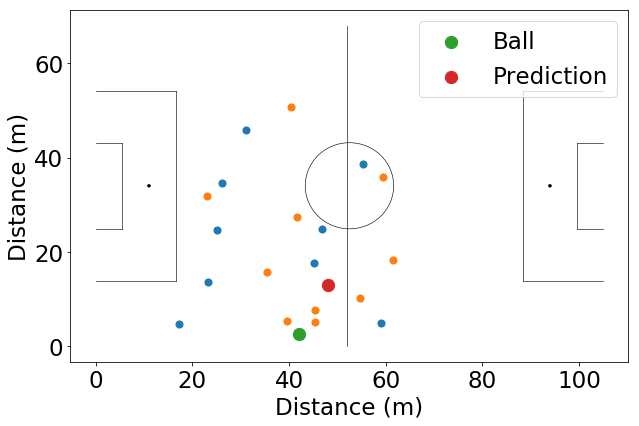

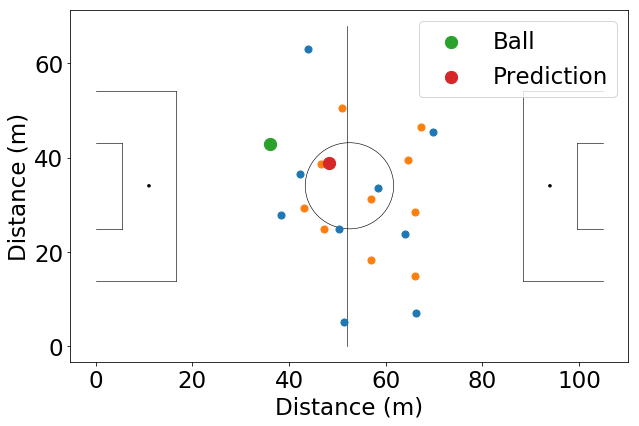

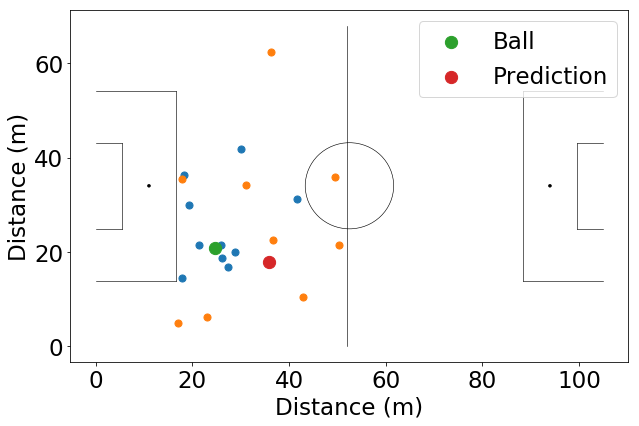

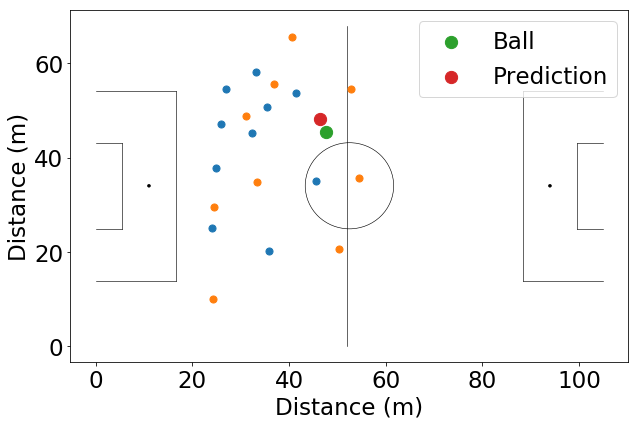

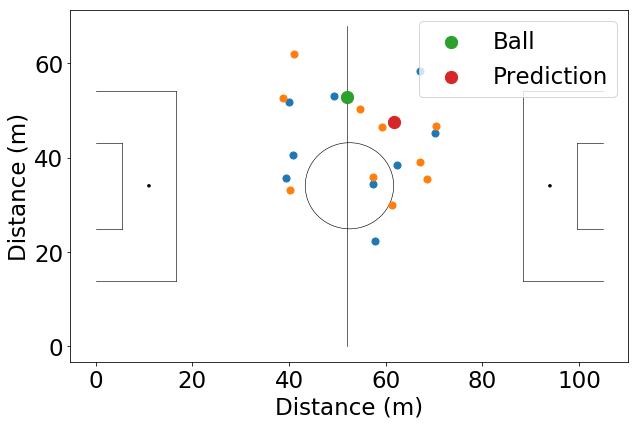

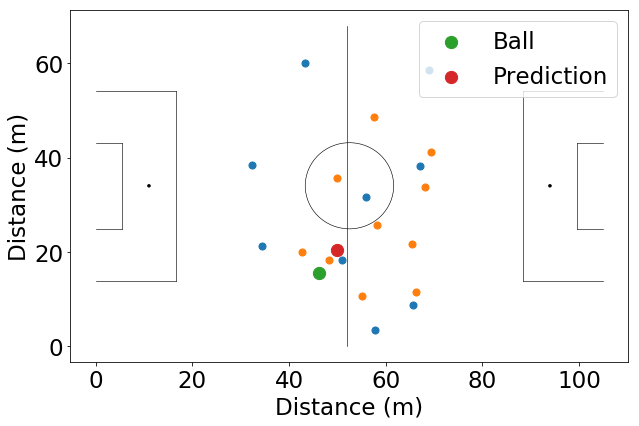

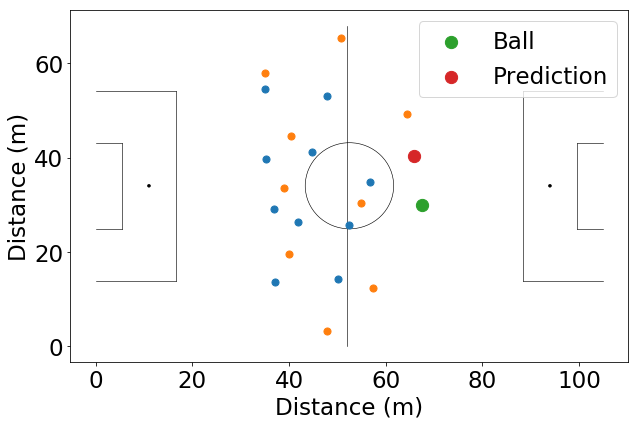

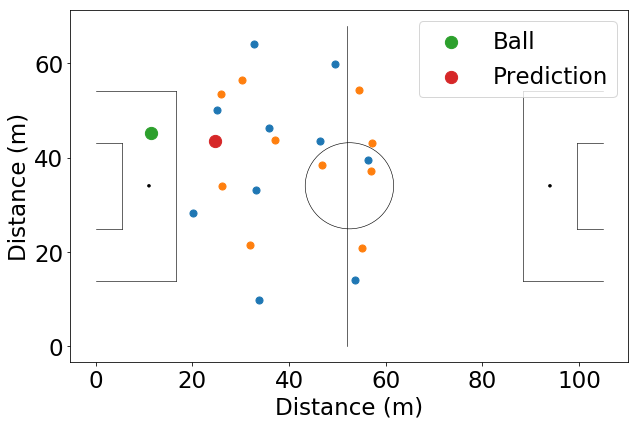

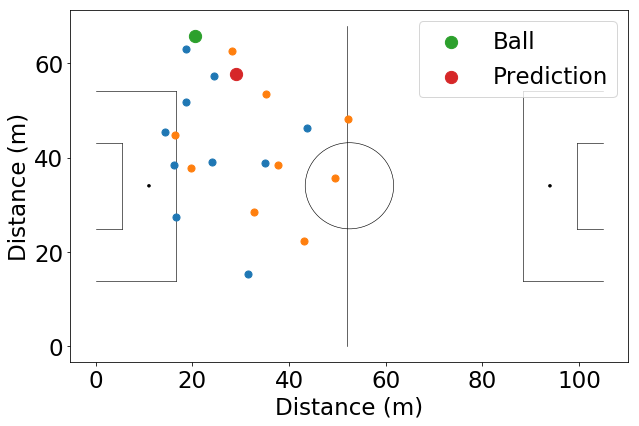

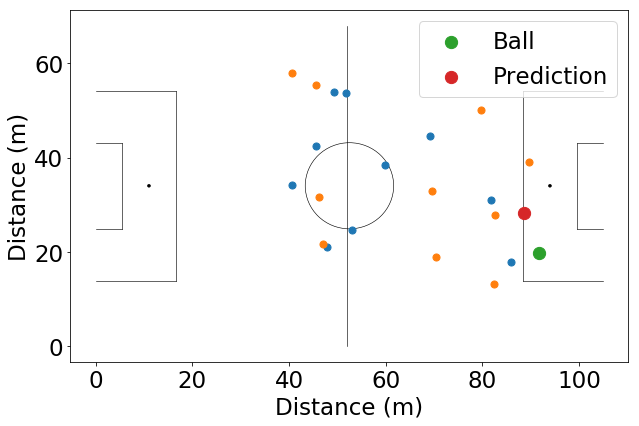

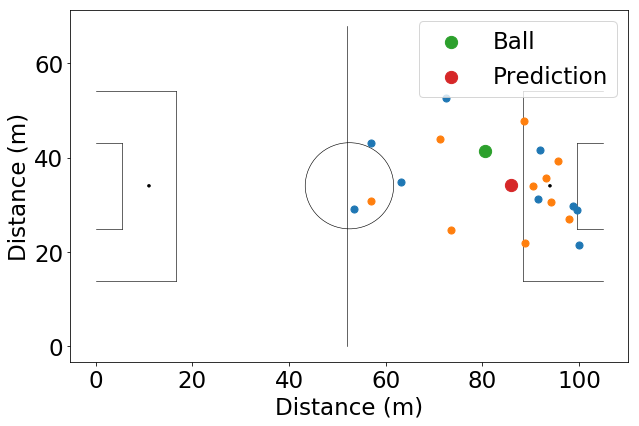

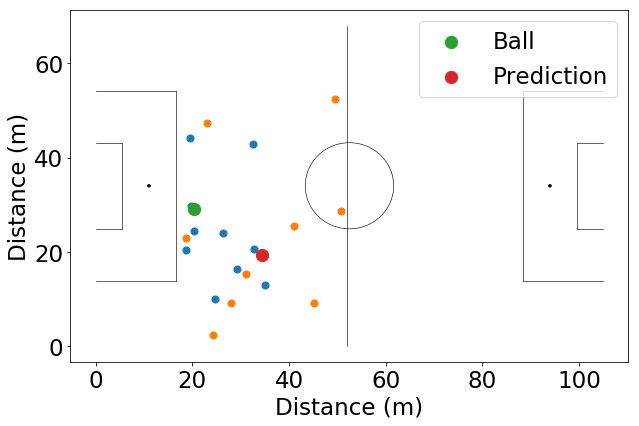

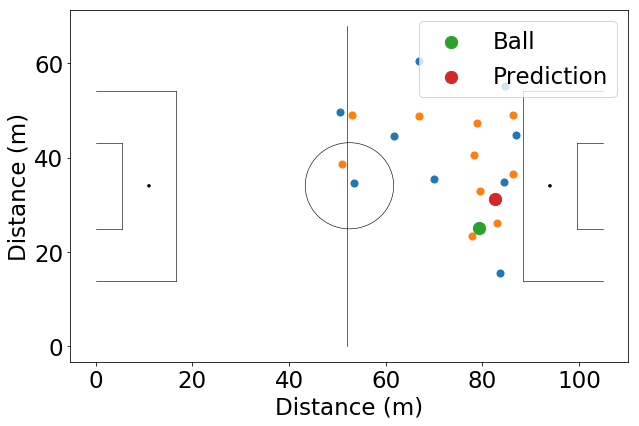

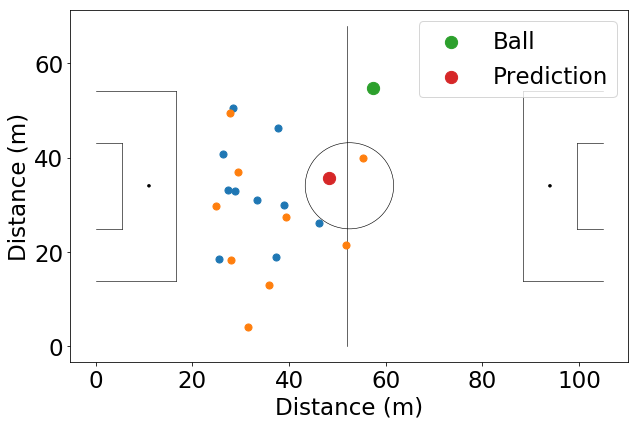

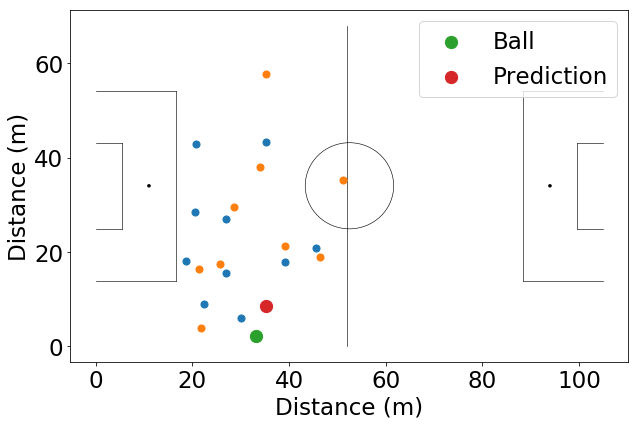

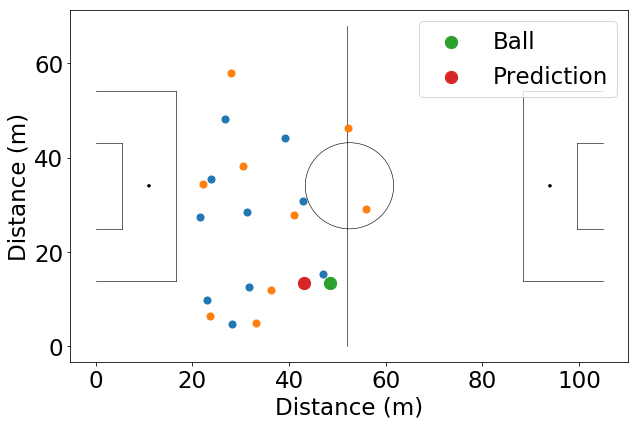

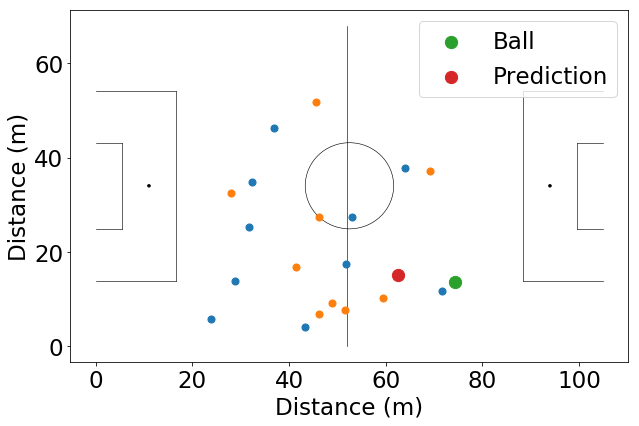

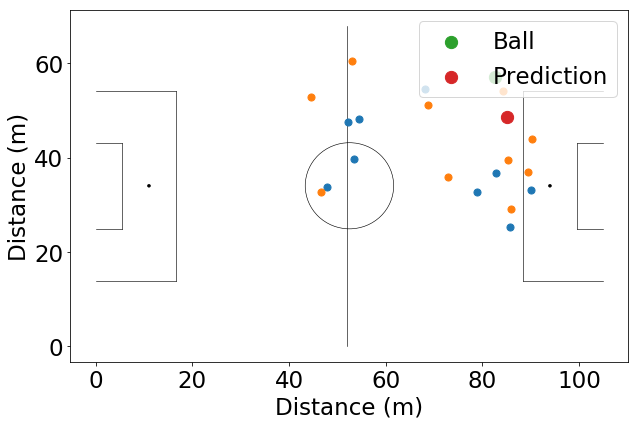

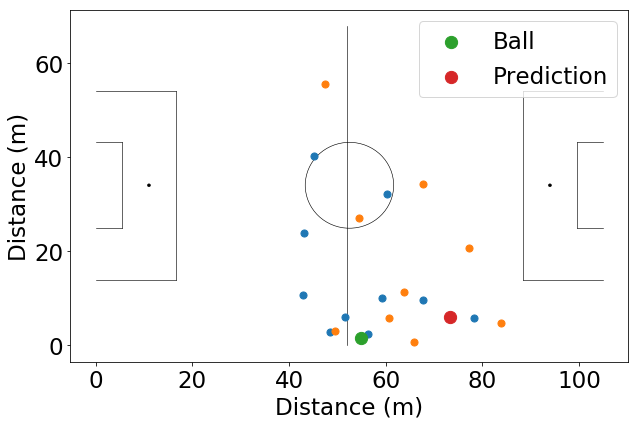

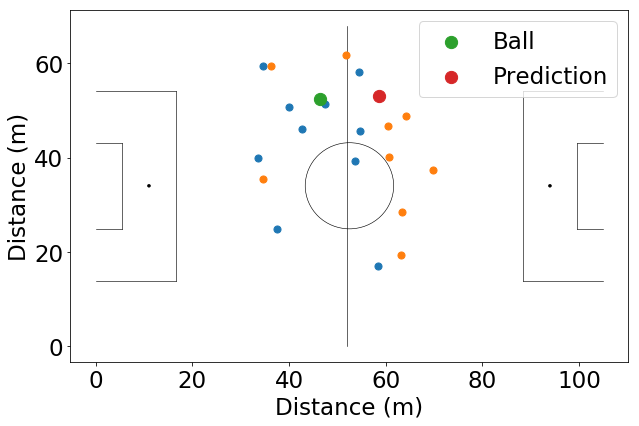

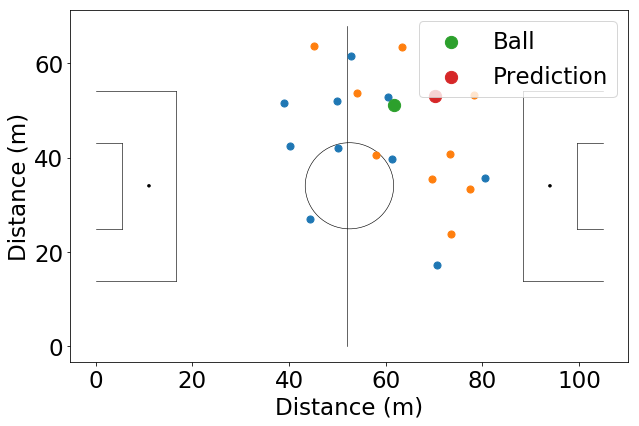

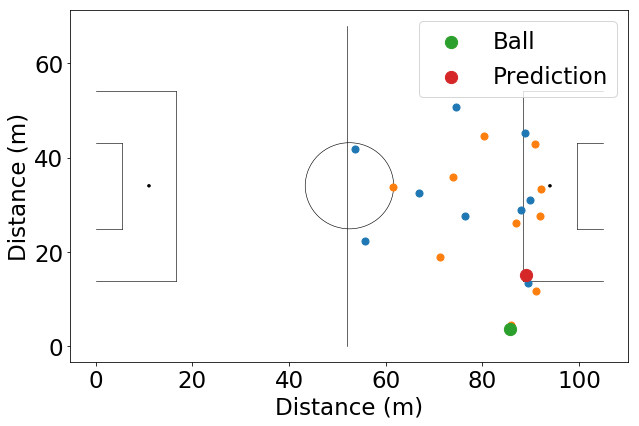

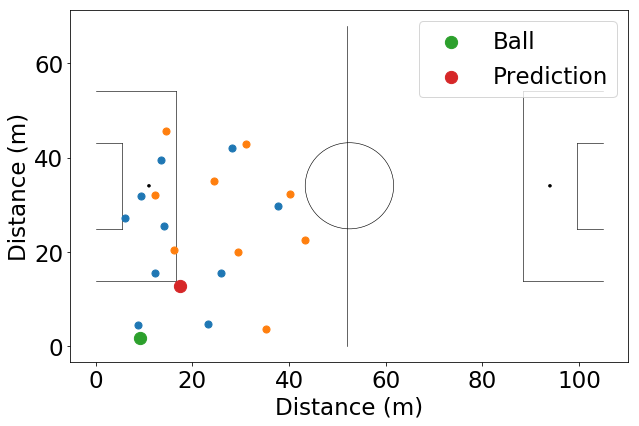

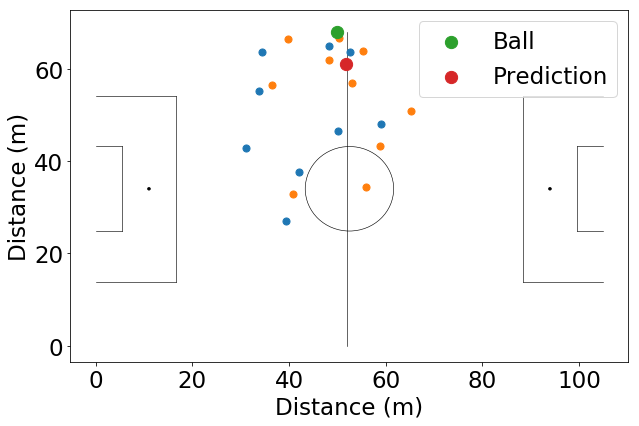

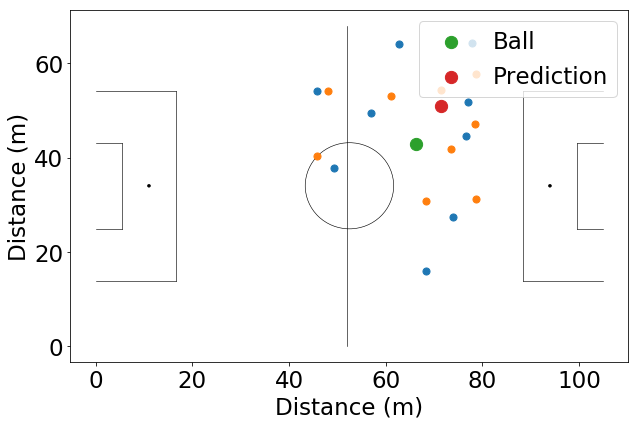

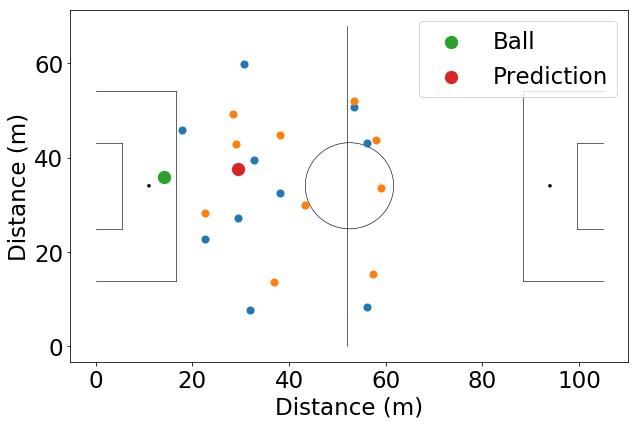

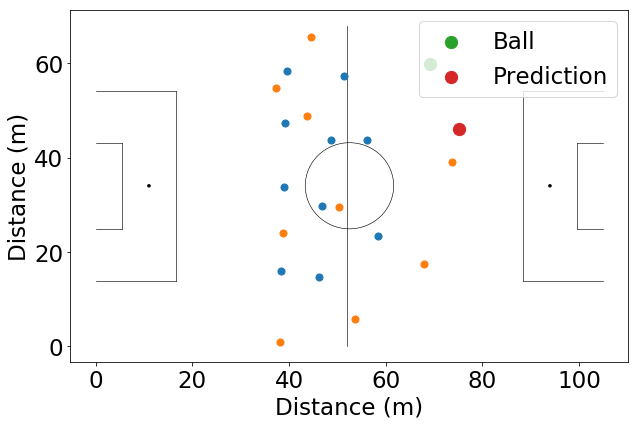

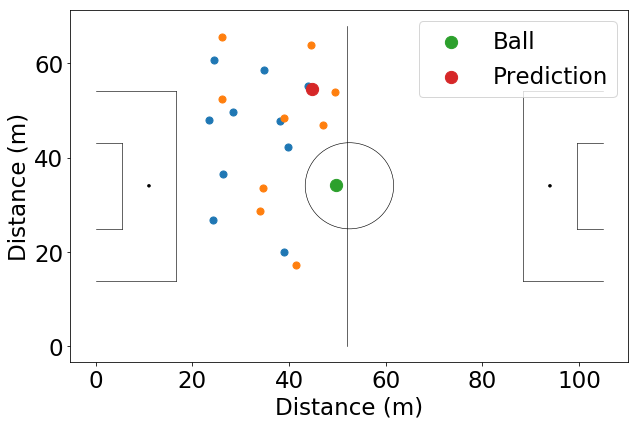

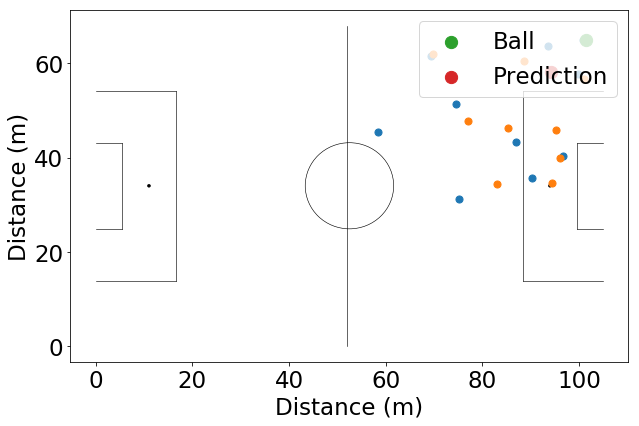

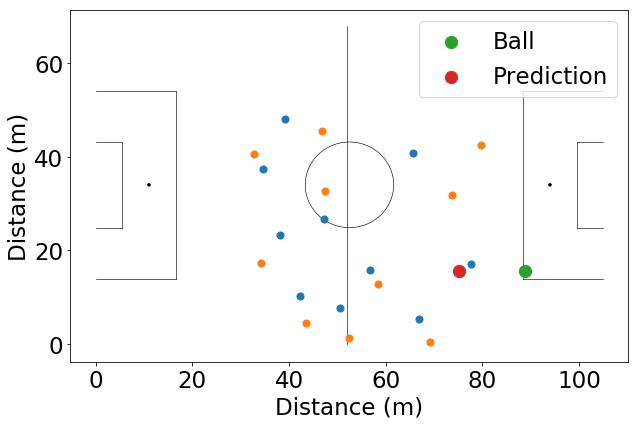

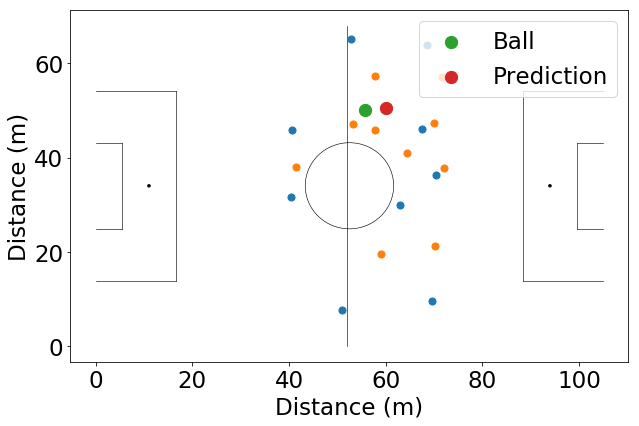

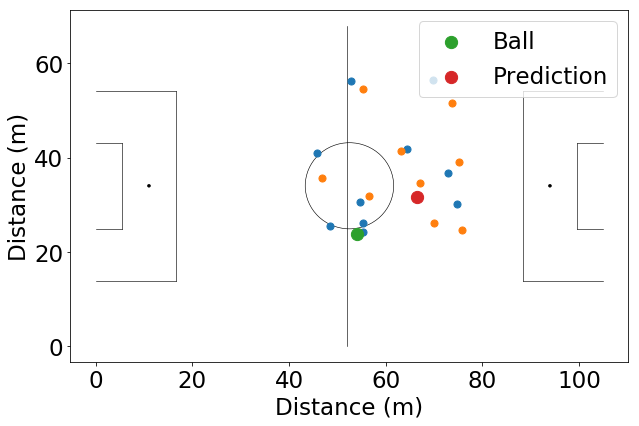

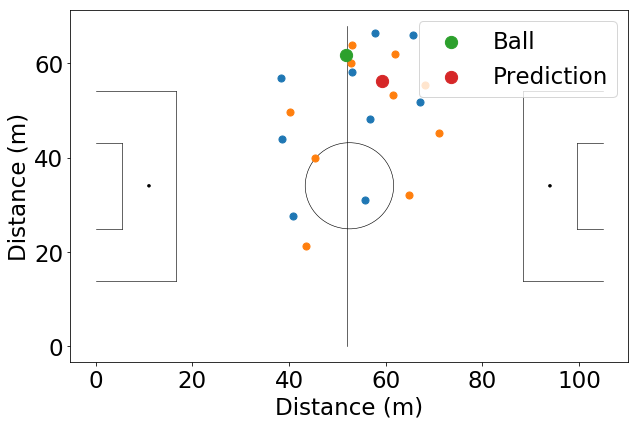

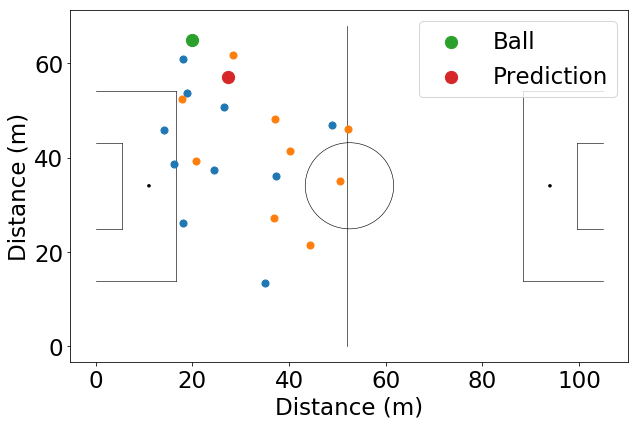

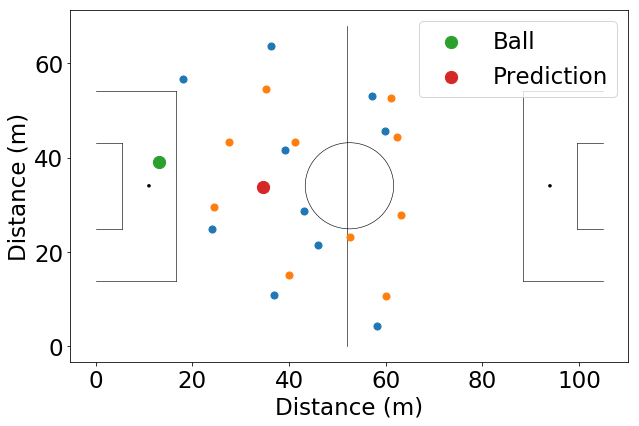

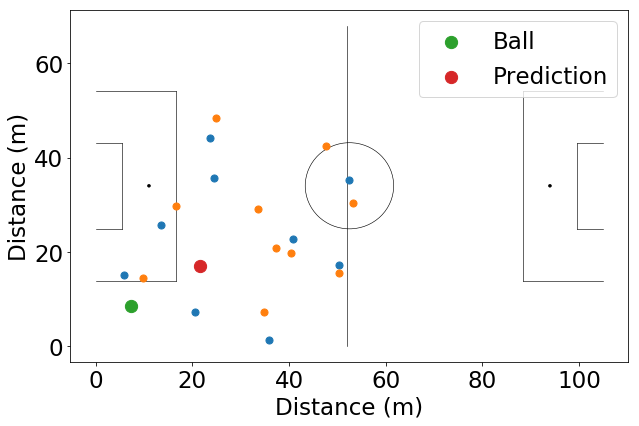

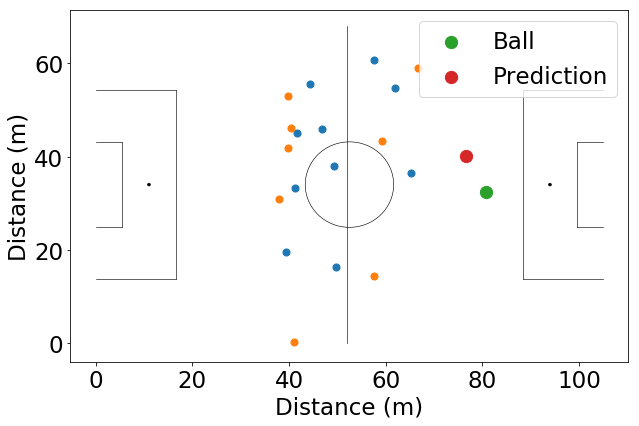

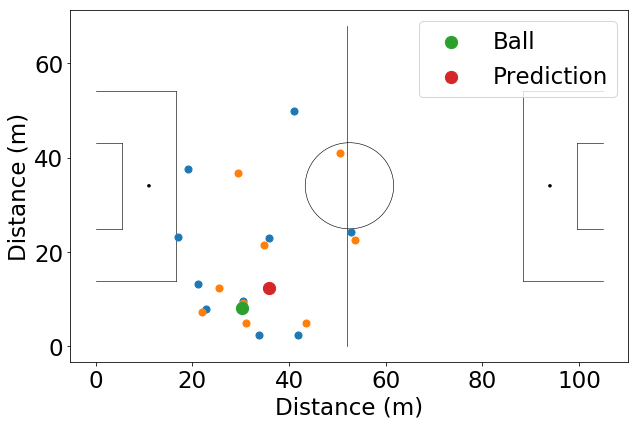

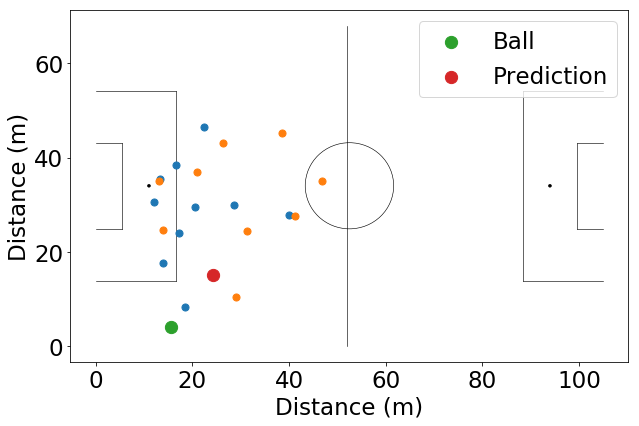

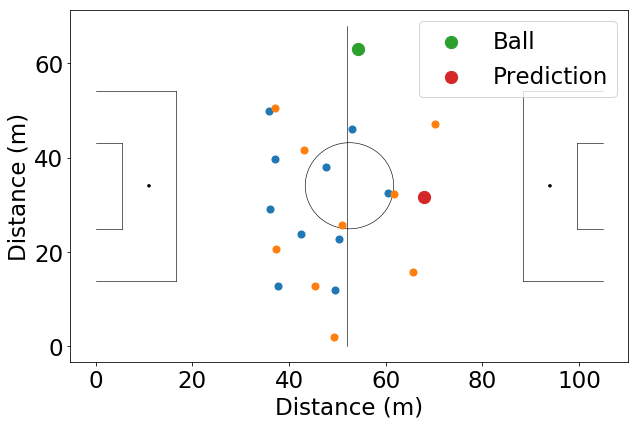

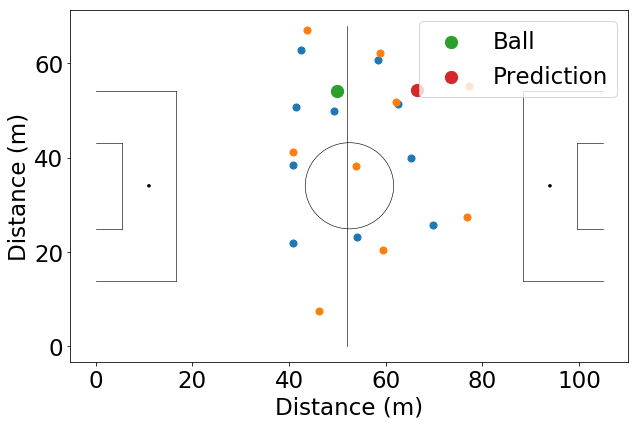

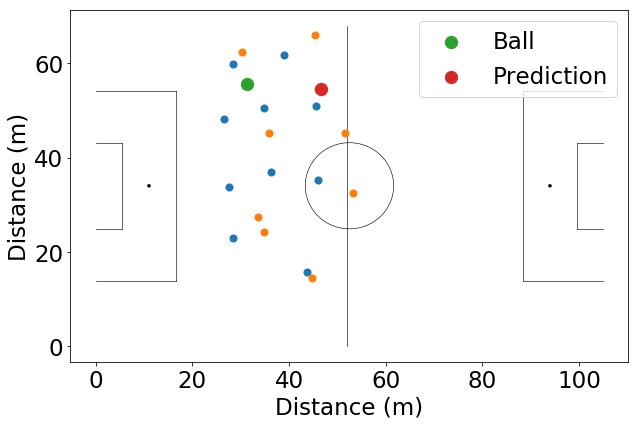

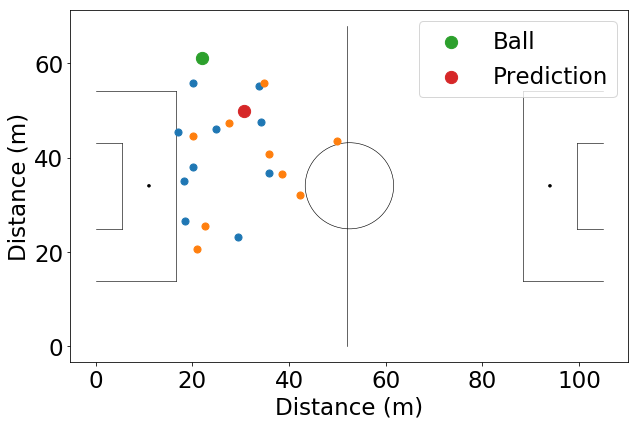

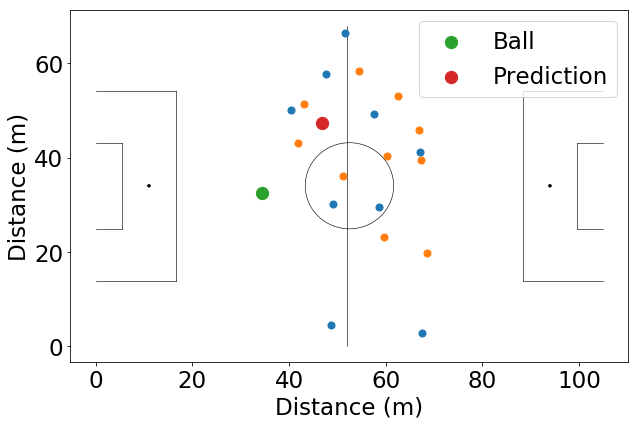

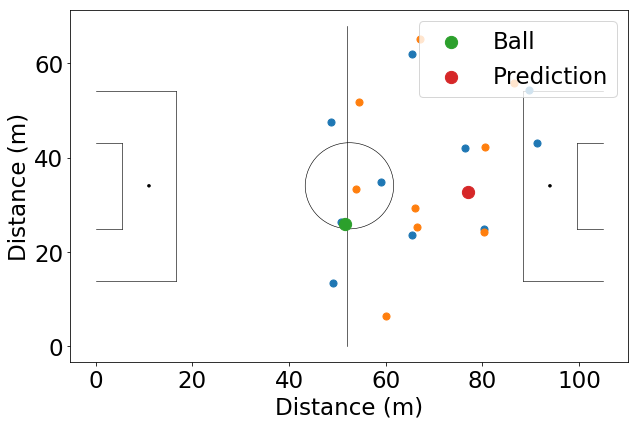

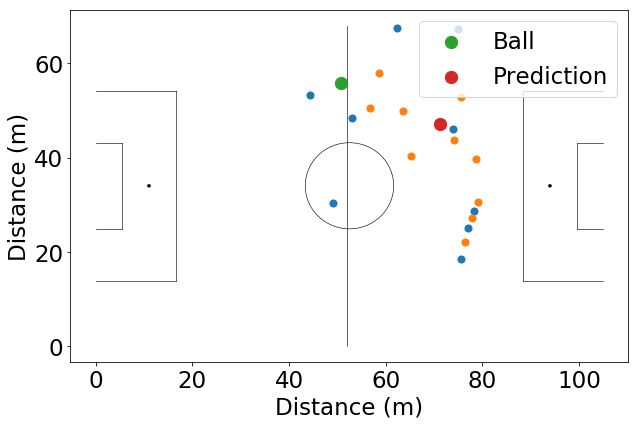

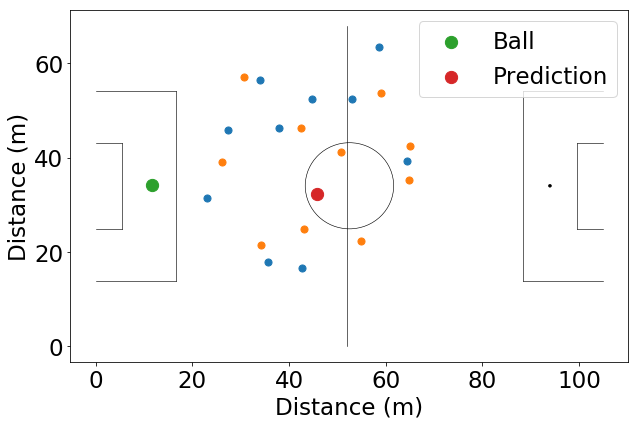

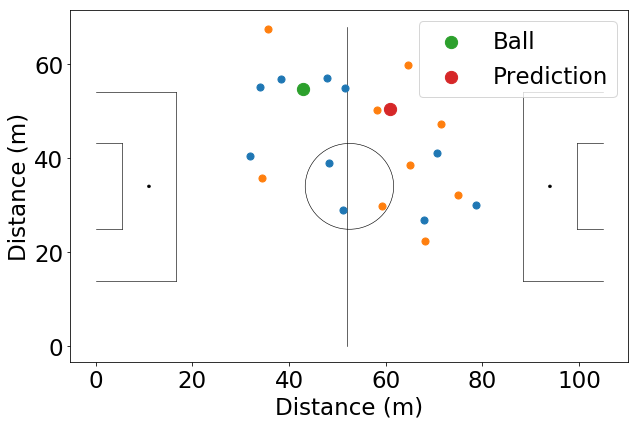

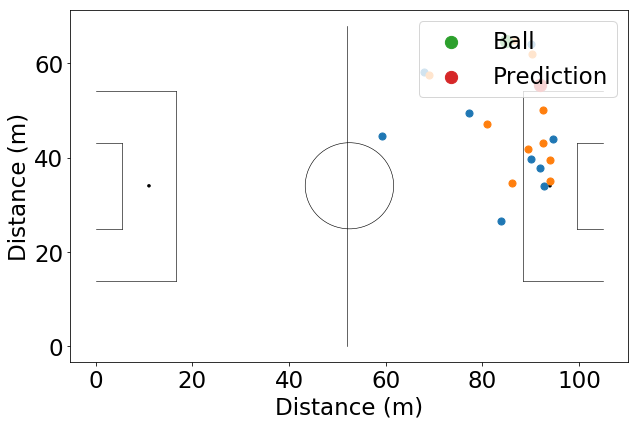

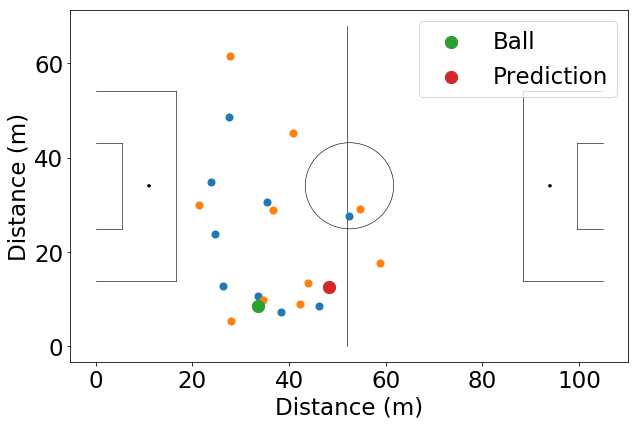

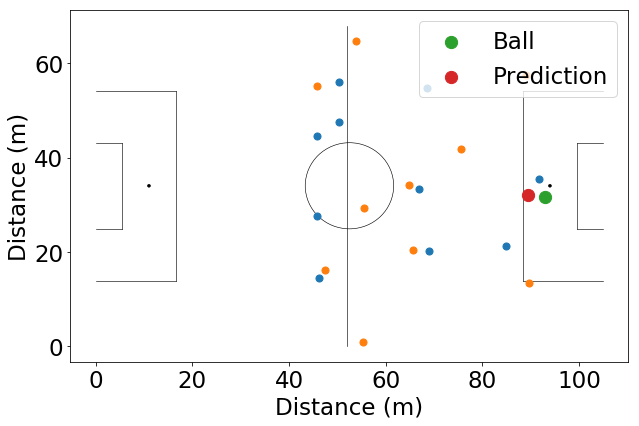

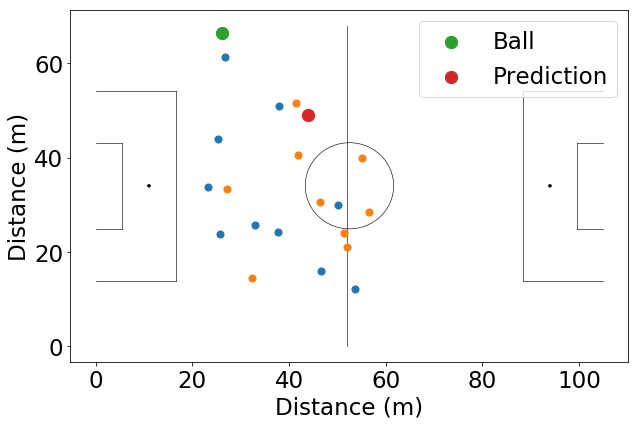

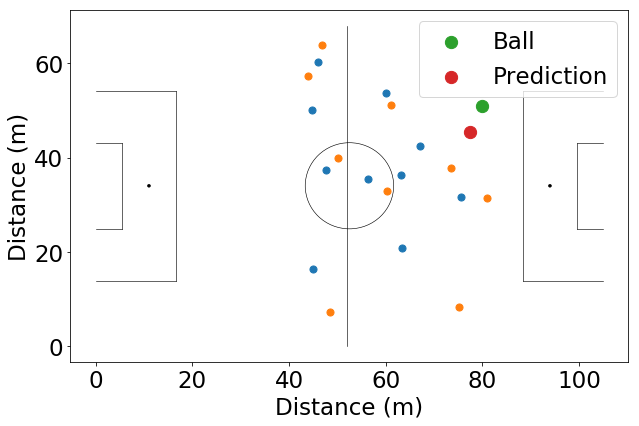

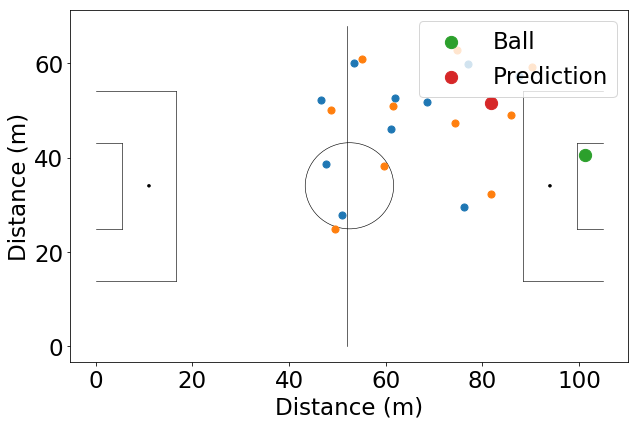

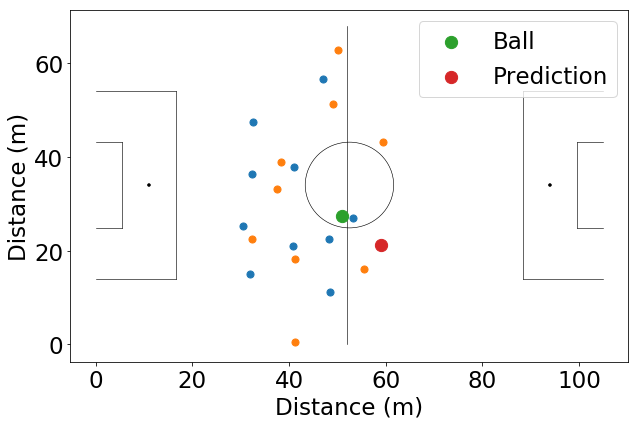

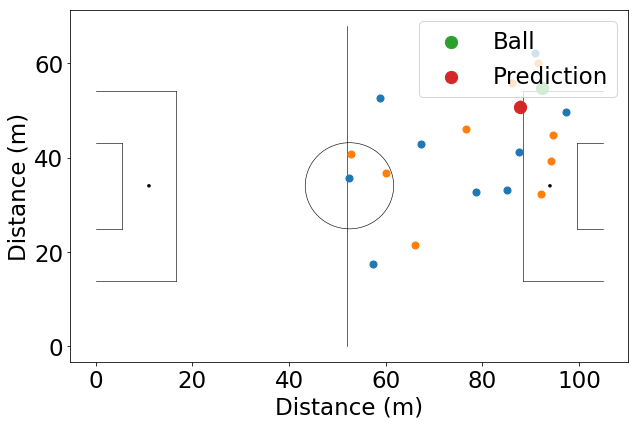

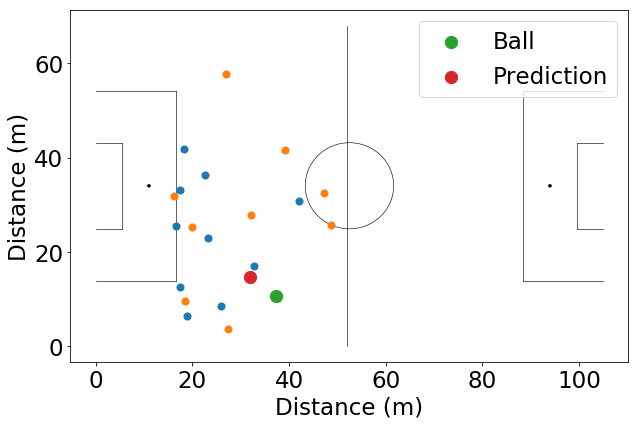

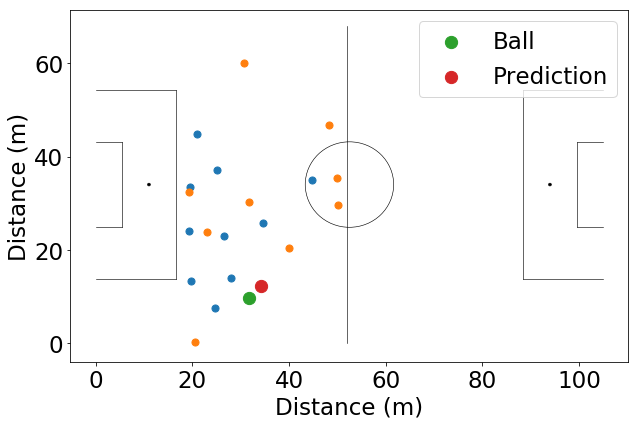

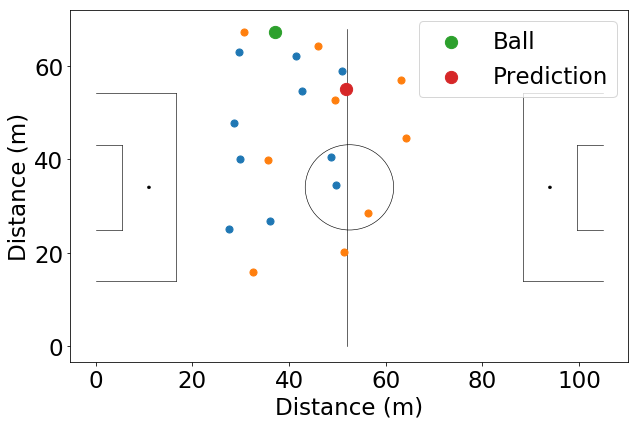

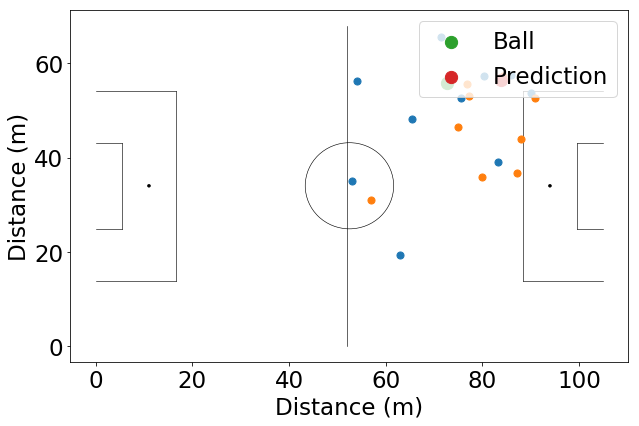

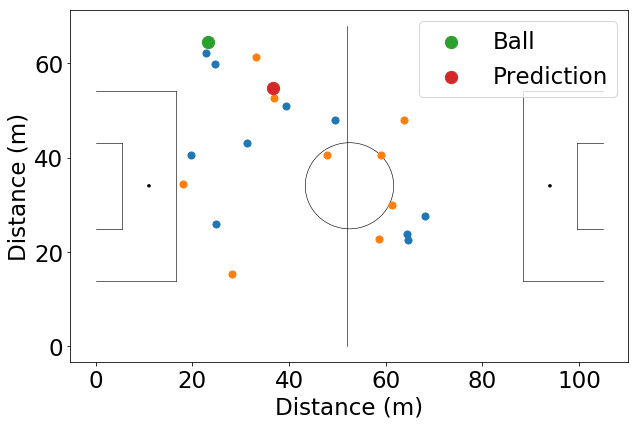

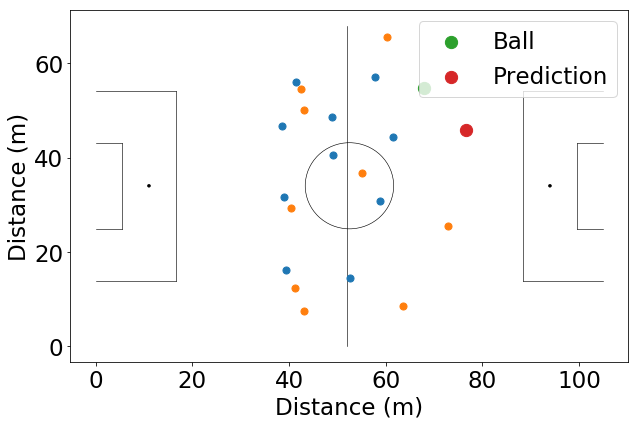

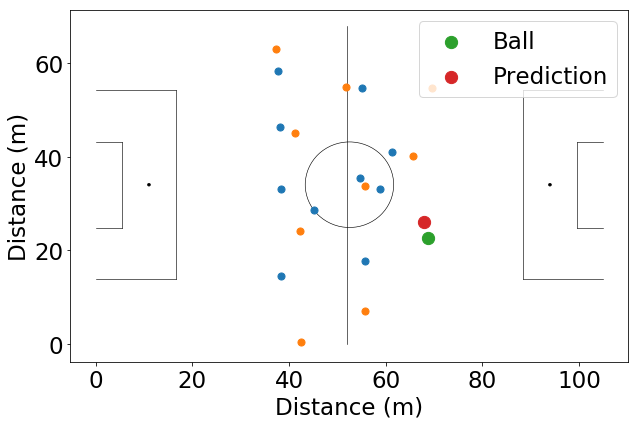

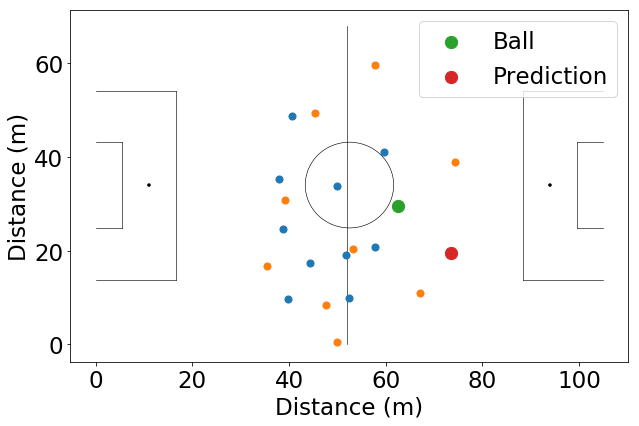

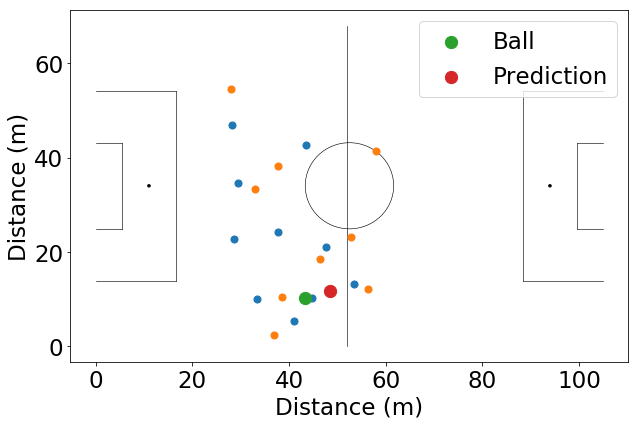

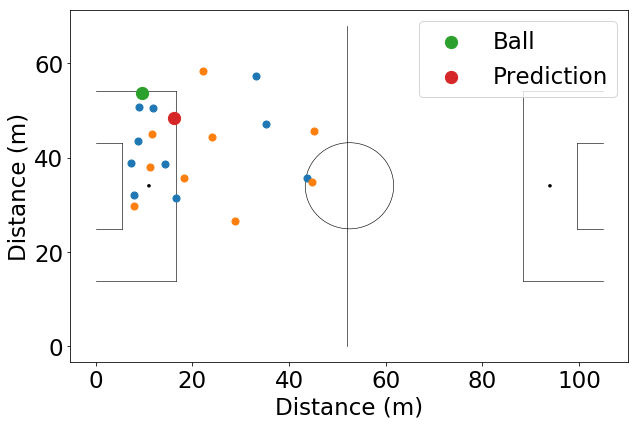

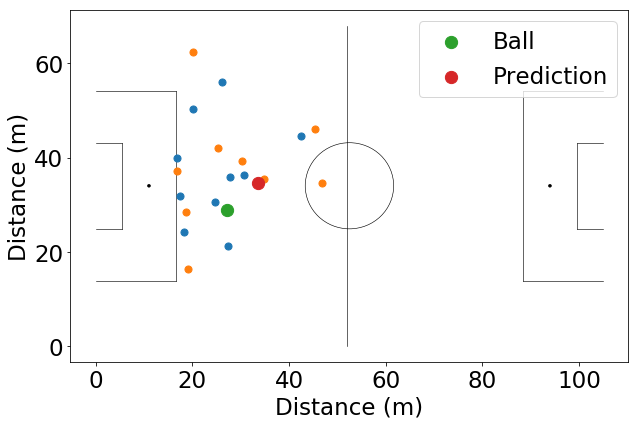

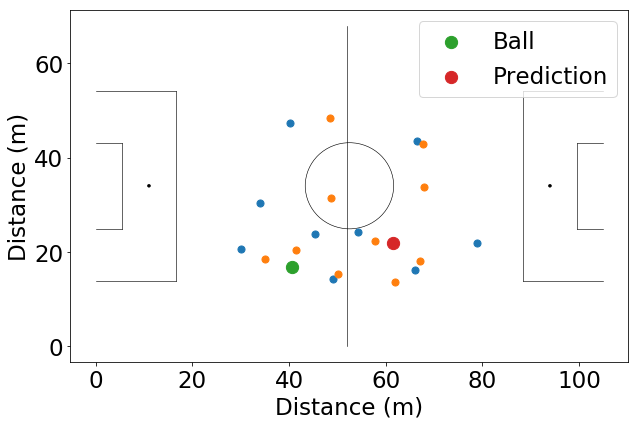

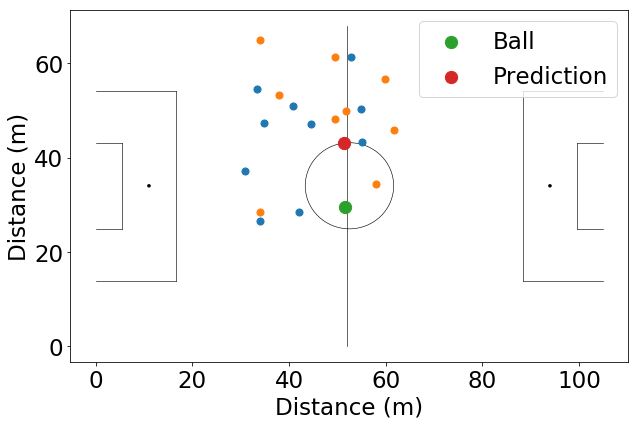

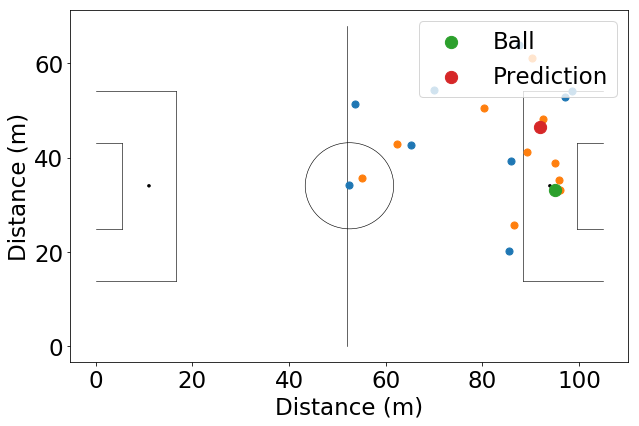

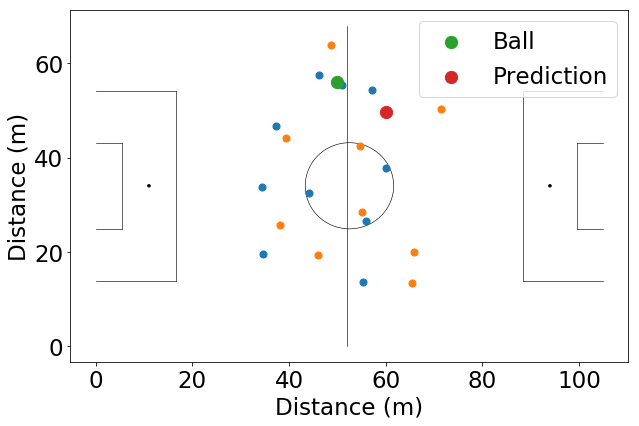

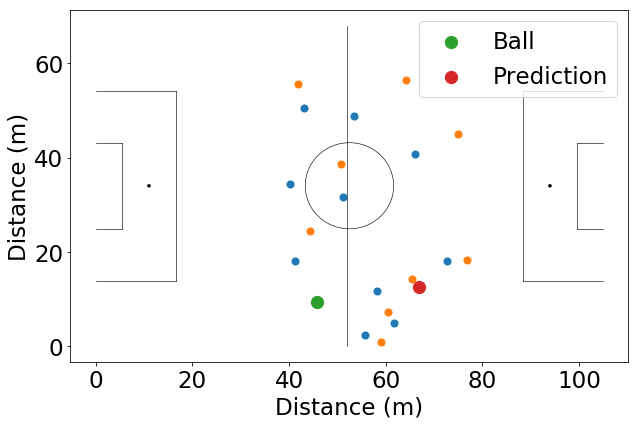

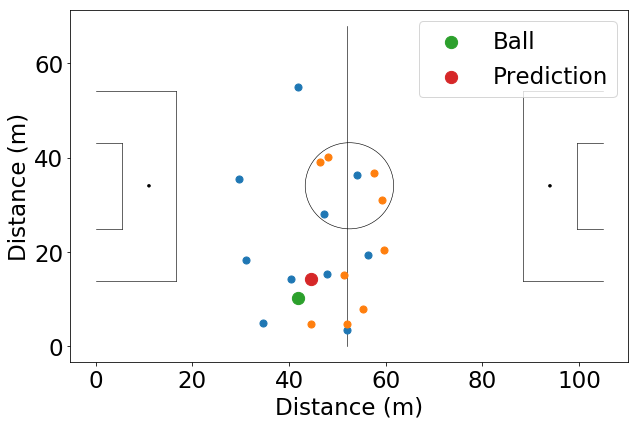

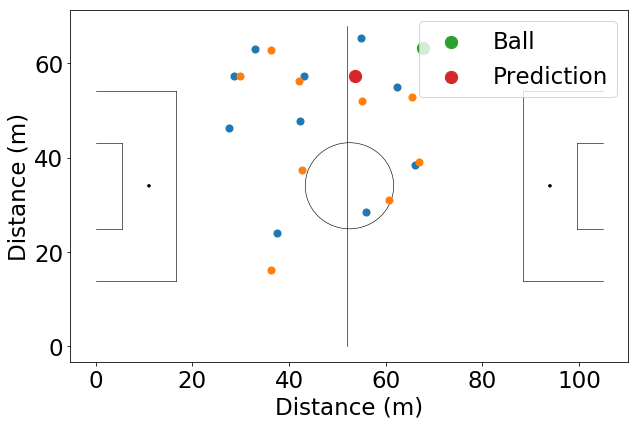

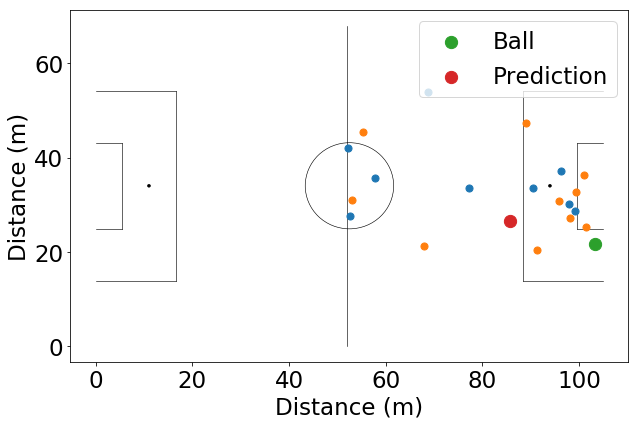

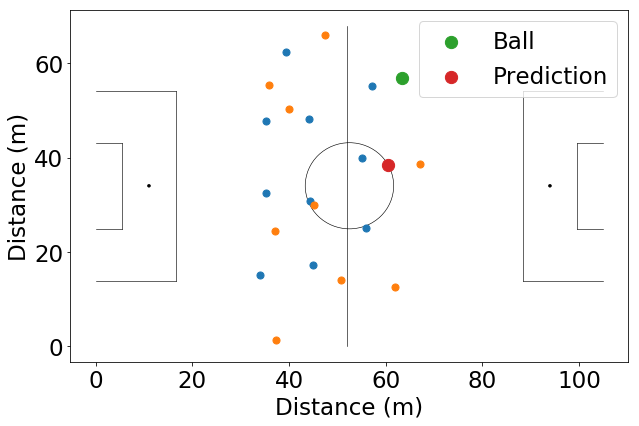

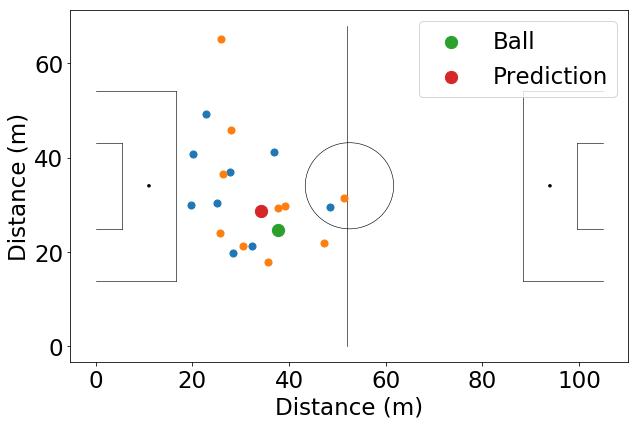

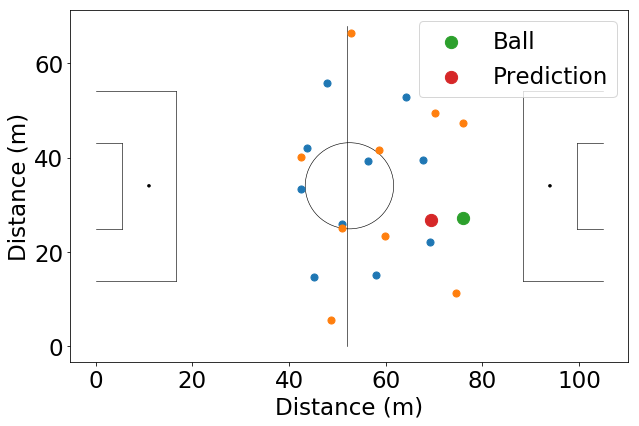

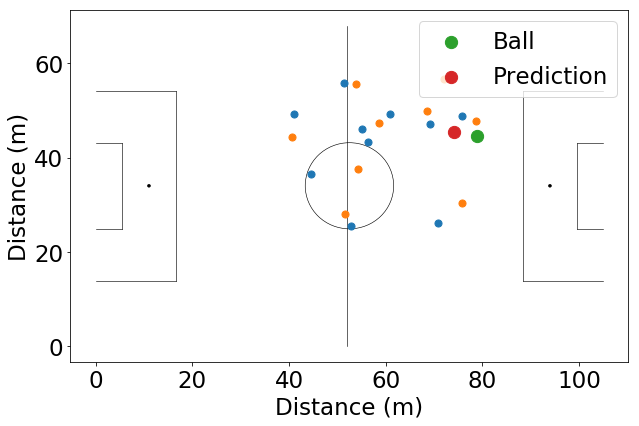

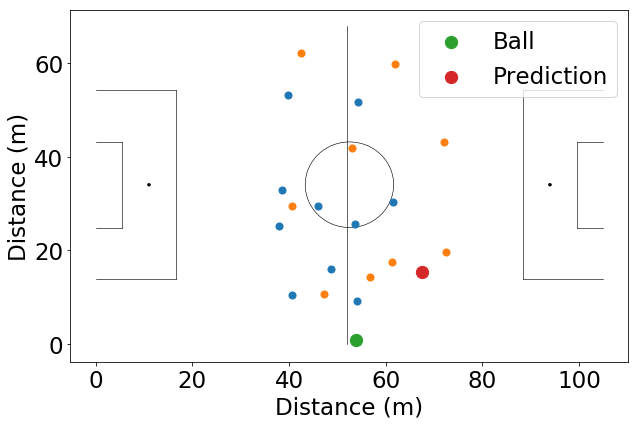

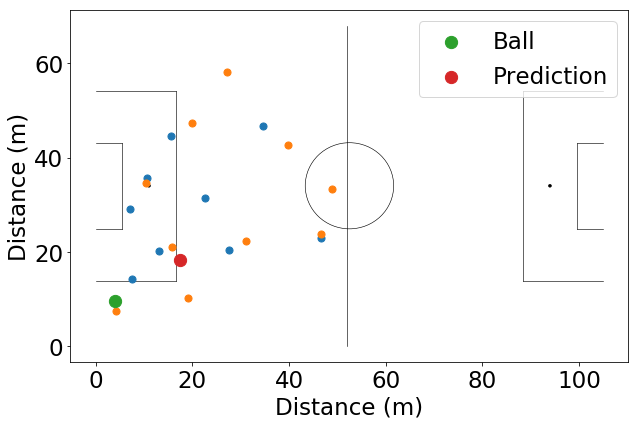

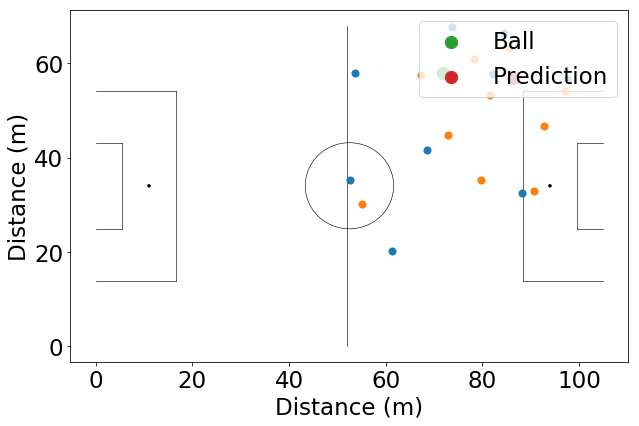

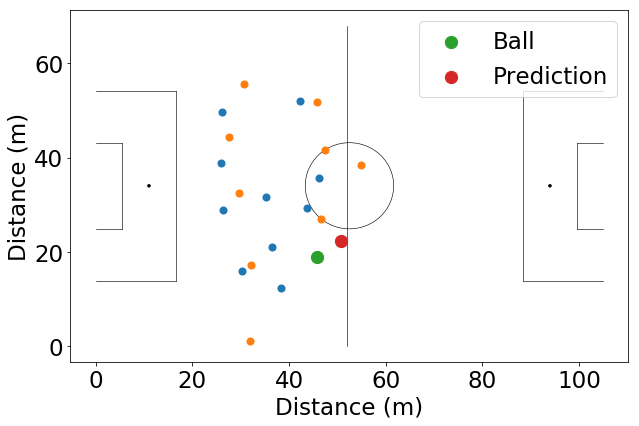

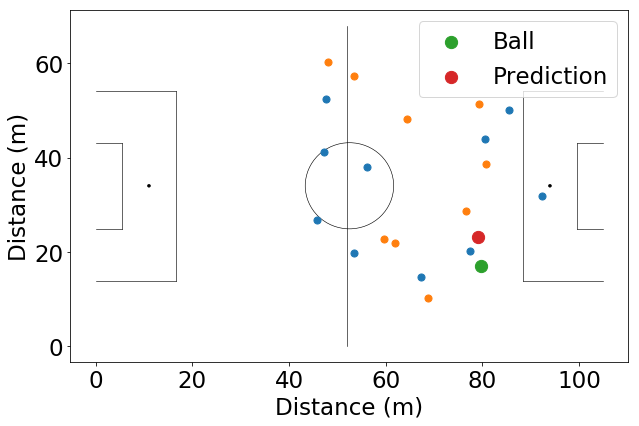

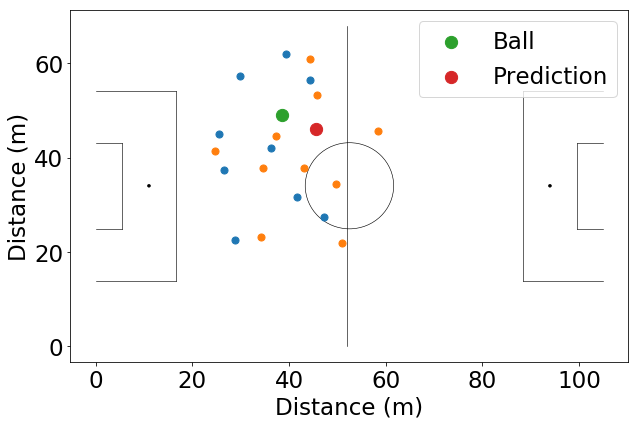

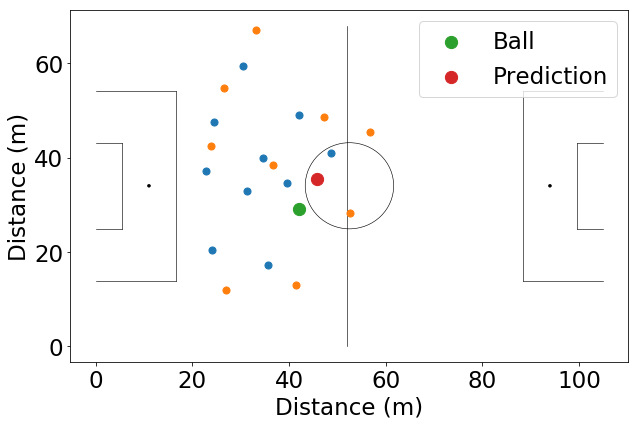

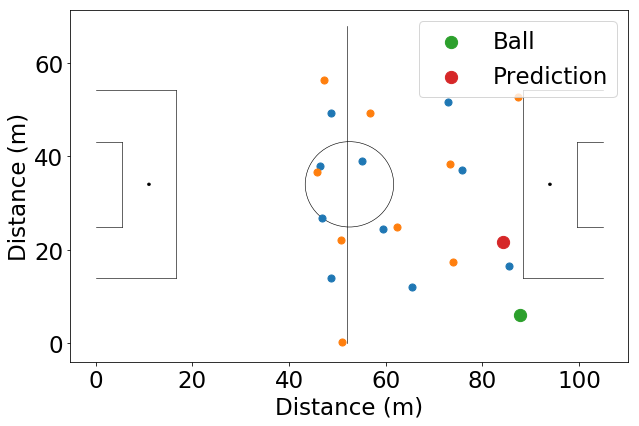

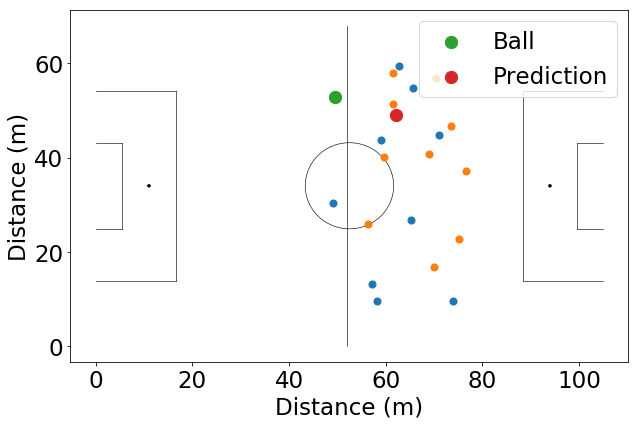

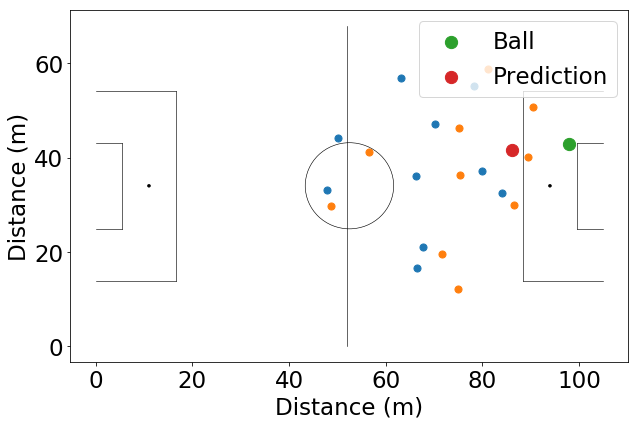

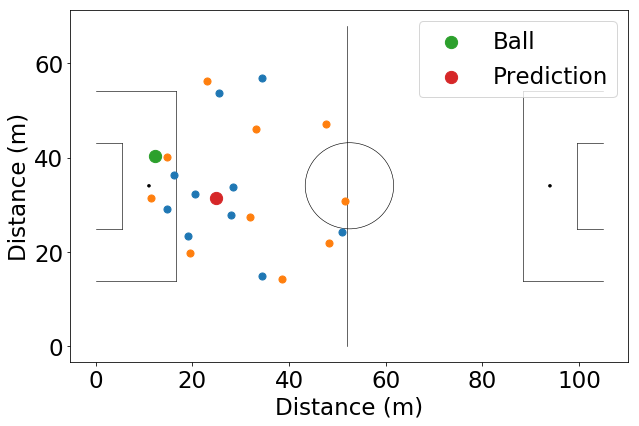

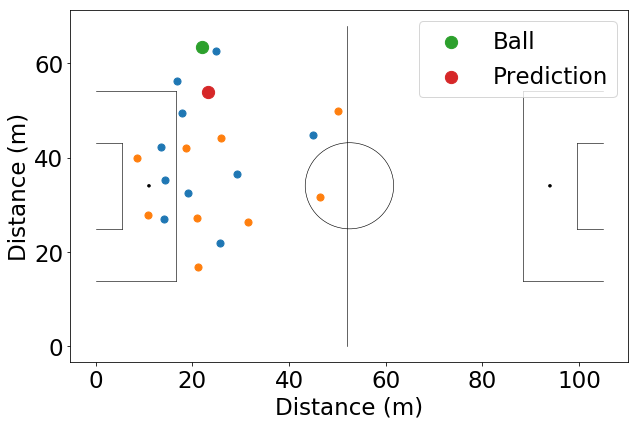

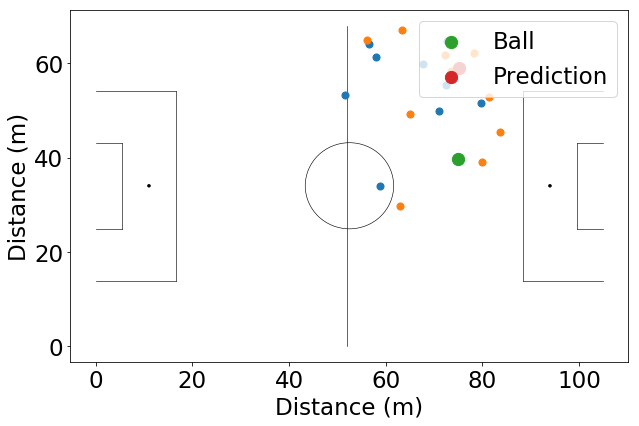

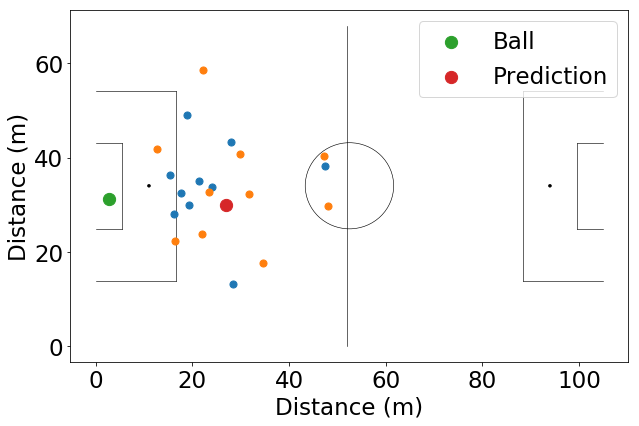

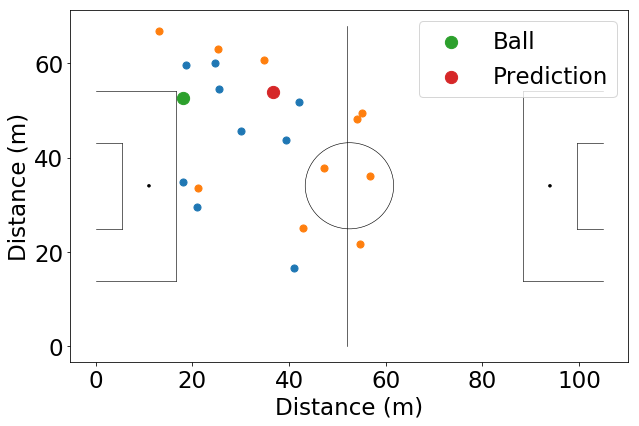

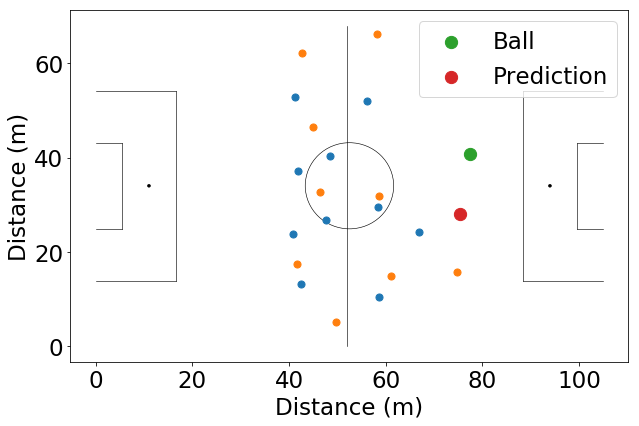

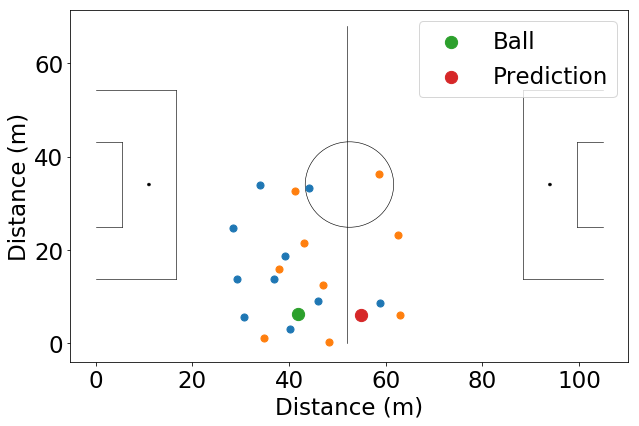

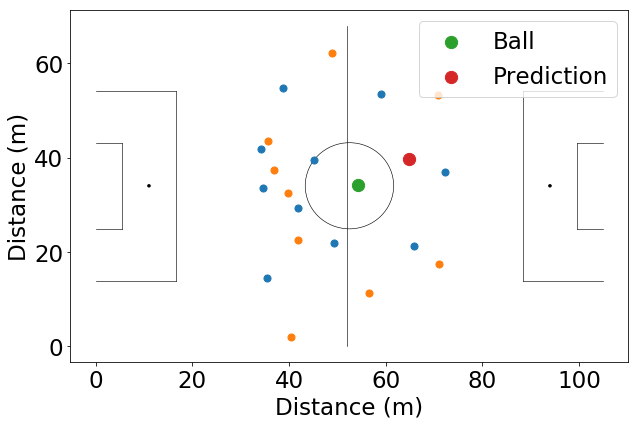

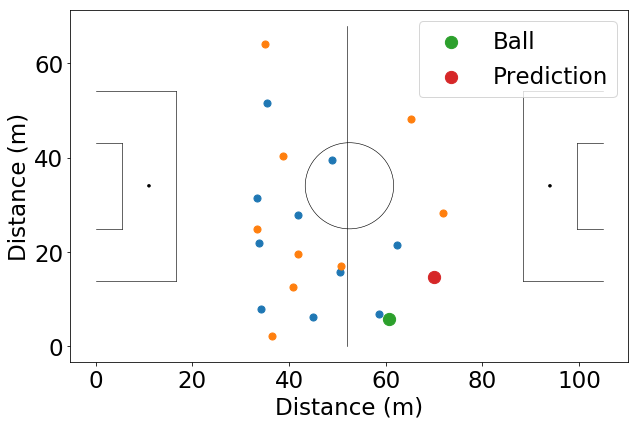

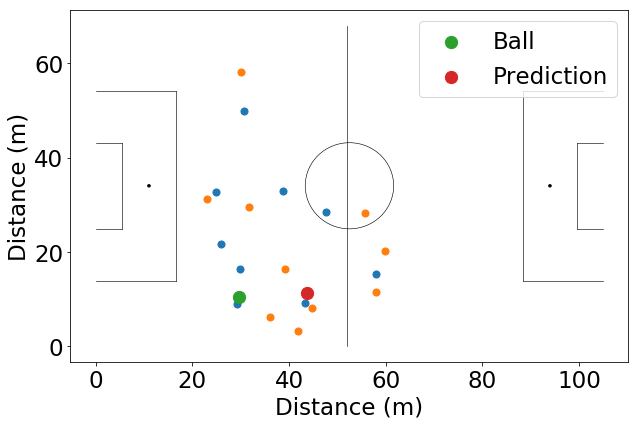

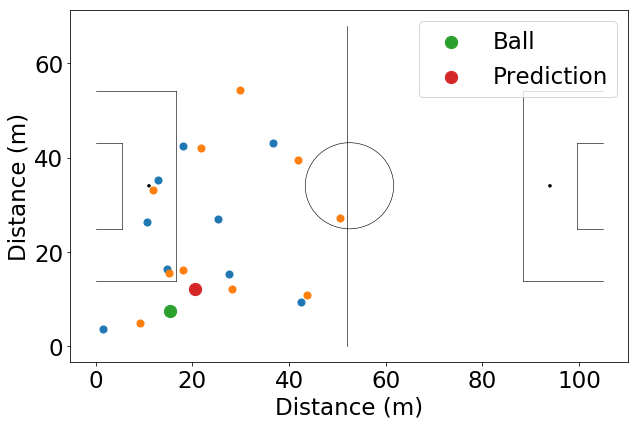

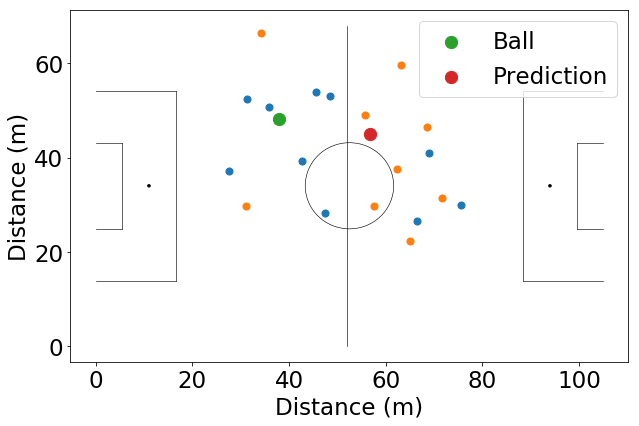

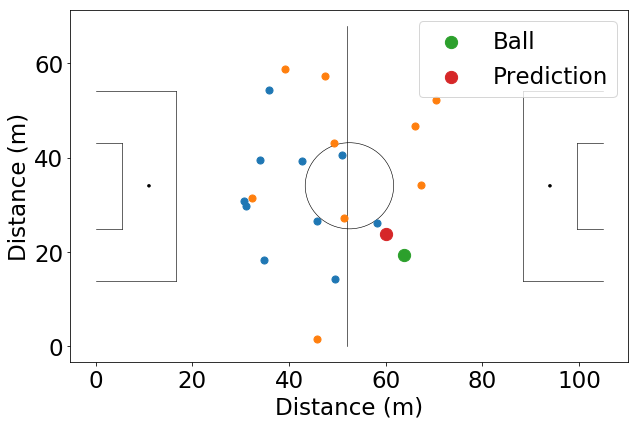

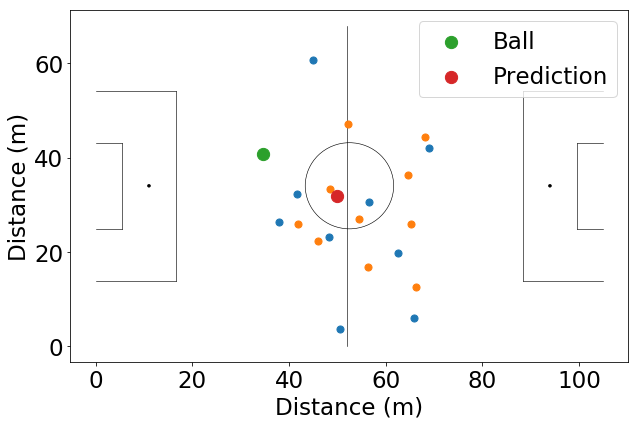

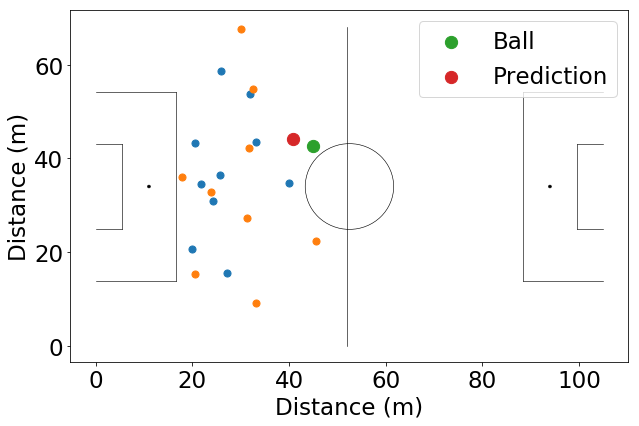

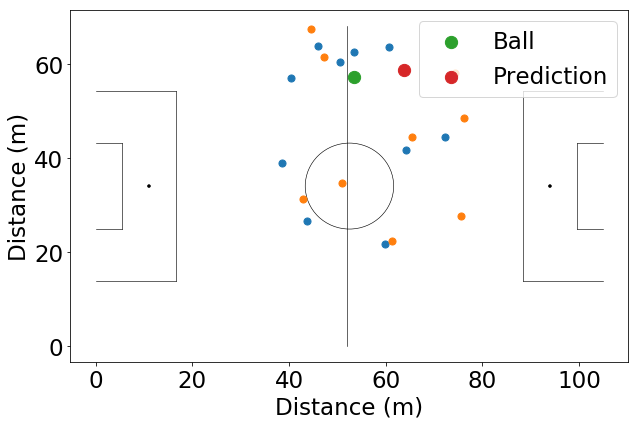

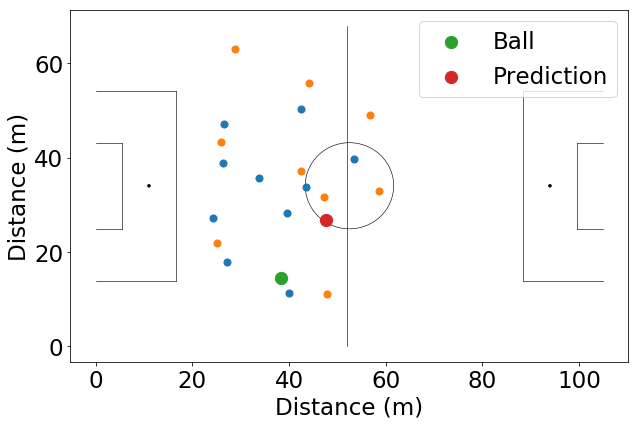

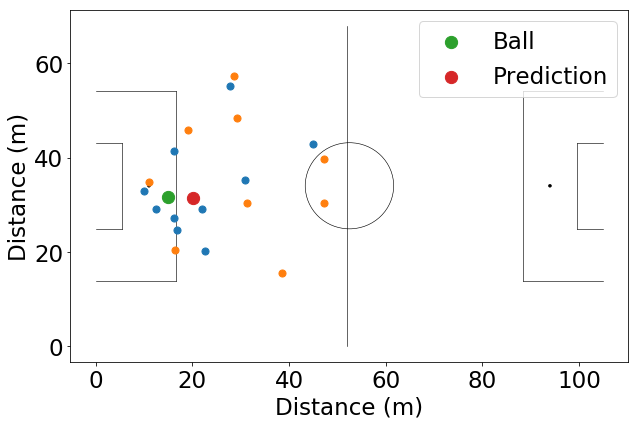

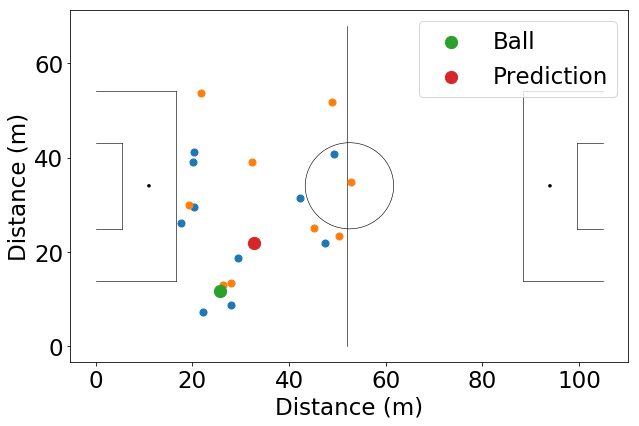

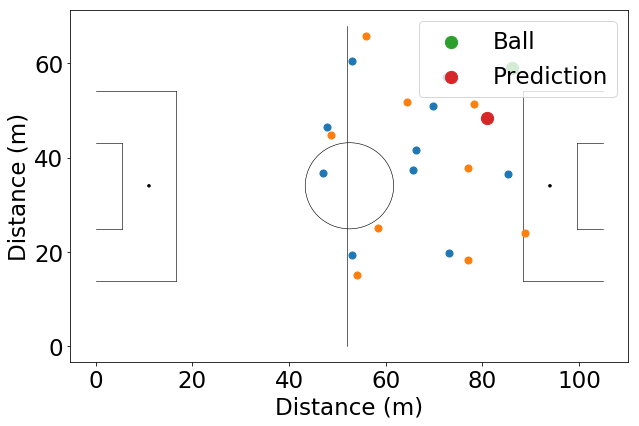

In [19]:
for i in range(len(idx)):
        plot_position(players_position[i][:10], players_position[i][10:20], players_position[i][20:30], players_position[i][30:40], y_x[i],y_y[i],p_y_x[i], p_y_y[i])